# GrIS ablation zone melt SEB seasonal variation (1940-2014, without GHF)

Author: Ziqi Yin

Last modified: 2025 Sep 26

Description: Causal inference of Greenland Ice Sheet summer surface melt
- Period: 1940-1969
- Frequency: monthly
- Region: ablation zone
- Variables: SWn, LWn, SH, LH
- Source:

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

import sys
home_dir = '/glade/work/ziqiyin/'
sys.path.insert(0, home_dir)
from copy import deepcopy

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

import tigramite
import tigramite.data_processing as pp
import tigramite.plotting as tp

from tigramite.models import LinearMediation, Models
from tigramite.causal_effects import CausalEffects

from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb

import cartopy
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec
from matplotlib.collections import PolyCollection
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

from scipy.stats import pearsonr

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/ziqiyin/conda-envs/my-npl-202306a/share/proj failed


In [2]:
# Function to remove seasonal mean and divide by seasonal standard deviation
def anomalize(dataseries, divide_by_std=True, reference_bounds = None, cycle_length=12, return_cycle=False):
    if reference_bounds is None:
        reference_bounds = (0, len(dataseries))

    anomaly = np.copy(dataseries)
    for t in range(cycle_length):
        if return_cycle:
            anomaly[t::cycle_length] = dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].mean(axis=0)
        else:
            anomaly[t::cycle_length] -= dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].mean(axis=0)
            if divide_by_std:
                anomaly[t::cycle_length] /= dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].std(axis=0)
    return anomaly

In [3]:
# Set Polar Sterographic Projection definition
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

## Load data

### 1940-1969

In [4]:
# CESM2-CISM2 f09
F09_GrIS_melt_monthly_1940_2014 = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/CESM2_F09/historical/CESM2_F09_GrIS_ablation_melt_monthly_hist_1940_2014.nc')['melt'] #[Gt/day]
F09_GrIS_SWn_monthly_1940_2014 = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/CESM2_F09/historical/CESM2_F09_GrIS_ablation_SWn_monthly_hist_1940_2014.nc')['SWn'] #[W/m2]
F09_GrIS_LWn_monthly_1940_2014 = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/CESM2_F09/historical/CESM2_F09_GrIS_ablation_LWn_monthly_hist_1940_2014.nc')['LWn'] #[W/m2]
F09_GrIS_SH_monthly_1940_2014 = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/CESM2_F09/historical/CESM2_F09_GrIS_ablation_SH_monthly_hist_1940_2014.nc')['SH'] #[W/m2]
F09_GrIS_LH_monthly_1940_2014 = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/CESM2_F09/historical/CESM2_F09_GrIS_ablation_LH_monthly_hist_1940_2014.nc')['LH'] #[W/m2]

In [11]:
## Area
Re = 6371.22 * 1e3 #[m]

f09_mask_file3 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v7.151020.nc'
f09_area = xr.open_dataset(f09_mask_file3)['area'] #[Radian2]
f09_area_Arctic = f09_area.where(f09_area.yc > 60).values * Re**2
f09_area = f09_area.values * Re**2

In [12]:
## Mask
# Generate Greenland mask
f09_mask_file1 = '/glade/work/aherring/grids/uniform-res/f09/clm_surfdata_5_0/surfdata_f09_hist_78pfts_CMIP6_simyr1850_c200429.nc'
f09_GrIS_mask0 = xr.open_dataset(f09_mask_file1)['GLACIER_REGION']
f09_GrIS_mask0 = xr.where(f09_GrIS_mask0==2, 1, np.nan)

# Land fraction of grid cell
f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active

In [13]:
Melt_dataset = np.zeros((50,30*12))
SWn_dataset = np.zeros((50,30*12))
LWn_dataset = np.zeros((50,30*12))
SH_dataset = np.zeros((50,30*12))
LH_dataset = np.zeros((50,30*12))

In [14]:
# CESM2 LENS2 50 CMIP6 ensembles
data_dir = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/lnd/proc/tseries/month_1/'

namelist = ['1001.001', '1021.002', '1041.003', '1061.004', '1081.005', '1101.006', '1121.007', '1141.008', '1161.009', '1181.010',
            '1231.001', '1231.002', '1231.003', '1231.004', '1231.005', '1231.006', '1231.007', '1231.008', '1231.009', '1231.010',
            '1251.001', '1251.002', '1251.003', '1251.004', '1251.005', '1251.006', '1251.007', '1251.008', '1251.009', '1251.010',
            '1281.001', '1281.002', '1281.003', '1281.004', '1281.005', '1281.006', '1281.007', '1281.008', '1281.009', '1281.010',
            '1301.001', '1301.002', '1301.003', '1301.004', '1301.005', '1301.006', '1301.007', '1301.008', '1301.009', '1301.010']
period = ['194001-194912', '195001-195912', '196001-196912']#, '197001-197912', '198001-198912', '199001-199912', '200001-200912', '201001-201412']

dates = pd.date_range("1940-01-01", periods=30*12, freq='M')

for index, num in enumerate(namelist):

    RAIN_monthly_list = []
    SNOW_monthly_list = []
    QICE_MELT_monthly_list = []
    QSNOMELT_monthly_list = []
    QFLX_EVAP_TOT_monthly_list = []
    QRUNOFF_monthly_list = []
    FSA_monthly_list = []
    FIRA_monthly_list = []
    FSH_monthly_list = []
    EFLX_LH_TOT_monthly_list = []
    PCT_LANDUNIT_monthly_list = []

    for j in period:
        RAIN_monthly_p = xr.open_dataset(data_dir+'RAIN/b.e21.BHISTcmip6.f09_g17.LE2-'+num+'.clm2.h0.RAIN.'+j+'.nc')['RAIN'] #[mm/s]
        SNOW_monthly_p = xr.open_dataset(data_dir+'SNOW/b.e21.BHISTcmip6.f09_g17.LE2-'+num+'.clm2.h0.SNOW.'+j+'.nc')['SNOW']
        QICE_MELT_monthly_p = xr.open_dataset(data_dir+'QICE_MELT/b.e21.BHISTcmip6.f09_g17.LE2-'+num+'.clm2.h0.QICE_MELT.'+j+'.nc')['QICE_MELT']
        QSNOMELT_monthly_p = xr.open_dataset(data_dir+'QSNOMELT/b.e21.BHISTcmip6.f09_g17.LE2-'+num+'.clm2.h0.QSNOMELT.'+j+'.nc')['QSNOMELT']
        QFLX_EVAP_TOT_monthly_p = xr.open_dataset(data_dir+'QFLX_EVAP_TOT/b.e21.BHISTcmip6.f09_g17.LE2-'+num+'.clm2.h0.QFLX_EVAP_TOT.'+j+'.nc')['QFLX_EVAP_TOT']
        QRUNOFF_monthly_p = xr.open_dataset(data_dir+'QRUNOFF/b.e21.BHISTcmip6.f09_g17.LE2-'+num+'.clm2.h0.QRUNOFF.'+j+'.nc')['QRUNOFF']
        FSA_monthly_p = xr.open_dataset(data_dir+'FSA/b.e21.BHISTcmip6.f09_g17.LE2-'+num+'.clm2.h0.FSA.'+j+'.nc')['FSA']
        FIRA_monthly_p = xr.open_dataset(data_dir+'FIRA/b.e21.BHISTcmip6.f09_g17.LE2-'+num+'.clm2.h0.FIRA.'+j+'.nc')['FIRA']
        FSH_monthly_p = xr.open_dataset(data_dir+'FSH/b.e21.BHISTcmip6.f09_g17.LE2-'+num+'.clm2.h0.FSH.'+j+'.nc')['FSH']
        EFLX_LH_TOT_monthly_p = xr.open_dataset(data_dir+'EFLX_LH_TOT/b.e21.BHISTcmip6.f09_g17.LE2-'+num+'.clm2.h0.EFLX_LH_TOT.'+j+'.nc')['EFLX_LH_TOT']
        PCT_LANDUNIT_monthly_p = xr.open_dataset(data_dir+'PCT_LANDUNIT/b.e21.BHISTcmip6.f09_g17.LE2-'+num+'.clm2.h0.PCT_LANDUNIT.'+j+'.nc')['PCT_LANDUNIT'][:,3,:,:]

        RAIN_monthly_list.append(RAIN_monthly_p)
        SNOW_monthly_list.append(SNOW_monthly_p)
        QICE_MELT_monthly_list.append(QICE_MELT_monthly_p)
        QSNOMELT_monthly_list.append(QSNOMELT_monthly_p)
        QFLX_EVAP_TOT_monthly_list.append(QFLX_EVAP_TOT_monthly_p)
        QRUNOFF_monthly_list.append(QRUNOFF_monthly_p)
        FSA_monthly_list.append(FSA_monthly_p)
        FIRA_monthly_list.append(FIRA_monthly_p)
        FSH_monthly_list.append(FSH_monthly_p)
        EFLX_LH_TOT_monthly_list.append(EFLX_LH_TOT_monthly_p)
        PCT_LANDUNIT_monthly_list.append(PCT_LANDUNIT_monthly_p)

    RAIN_monthly = xr.concat(RAIN_monthly_list, dim='time')
    SNOW_monthly = xr.concat(SNOW_monthly_list, dim='time')
    QICE_MELT_monthly = xr.concat(QICE_MELT_monthly_list, dim='time')
    QSNOMELT_monthly = xr.concat(QSNOMELT_monthly_list, dim='time')
    QFLX_EVAP_TOT_monthly = xr.concat(QFLX_EVAP_TOT_monthly_list, dim='time')
    QRUNOFF_monthly = xr.concat(QRUNOFF_monthly_list, dim='time')
    FSA_monthly = xr.concat(FSA_monthly_list, dim='time')
    FIRA_monthly = xr.concat(FIRA_monthly_list, dim='time')
    FSH_monthly = xr.concat(FSH_monthly_list, dim='time')
    EFLX_LH_TOT_monthly = xr.concat(EFLX_LH_TOT_monthly_list, dim='time')
    PCT_LANDUNIT_monthly = xr.concat(PCT_LANDUNIT_monthly_list, dim='time')

    RAIN_monthly['time'] = dates
    SNOW_monthly['time'] = dates
    QICE_MELT_monthly['time'] = dates
    QSNOMELT_monthly['time'] = dates
    QFLX_EVAP_TOT_monthly['time'] = dates
    QRUNOFF_monthly['time'] = dates
    FSA_monthly['time'] = dates
    FIRA_monthly['time'] = dates
    FSH_monthly['time'] = dates
    EFLX_LH_TOT_monthly['time'] = dates
    PCT_LANDUNIT_monthly['time'] = dates

    # GrIS mask
    f09_glacier_frac = PCT_LANDUNIT_monthly
    f09_GrIS_mask = f09_GrIS_mask0.values * f09_glacier_frac * f09_land_frac.values / 100

    # Ablation zone
    days_in_month_percent = RAIN_monthly.time.dt.days_in_month / 365
    year = RAIN_monthly.time.dt.year
    RAIN_yearly = (RAIN_monthly * days_in_month_percent).groupby(year).sum(dim='time') #[mm/s]
    SNOW_yearly = (SNOW_monthly * days_in_month_percent).groupby(year).sum(dim='time')
    QRUNOFF_yearly = (QRUNOFF_monthly * days_in_month_percent).groupby(year).sum(dim='time')
    QFLX_EVAP_TOT_yearly = (QFLX_EVAP_TOT_monthly * days_in_month_percent).groupby(year).sum(dim='time')
    smb_yearly = RAIN_yearly + SNOW_yearly - QRUNOFF_yearly - QFLX_EVAP_TOT_yearly
    smb_yearly_mean = smb_yearly.mean(dim='year')
    f09_GrIS_mask = f09_GrIS_mask.where(smb_yearly_mean<0)

    if num == '1001.001':
        f09_GrIS_mask_n1 = f09_GrIS_mask

    # Calculate
    int_QICE_MELT_monthly = (QICE_MELT_monthly * f09_GrIS_mask.values * f09_area).sum(dim=['lon','lat'])
    int_QSNOMELT_monthly = (QSNOMELT_monthly * f09_GrIS_mask.values * f09_area).sum(dim=['lon','lat'])
    int_MELT_monthly = int_QICE_MELT_monthly + int_QSNOMELT_monthly
    int_SWn_monthly = (FSA_monthly * f09_GrIS_mask.values * f09_area).sum(dim=['lon','lat']) /(f09_GrIS_mask * f09_area).sum(dim=['lon','lat'])
    int_LWn_monthly = -(FIRA_monthly * f09_GrIS_mask.values * f09_area).sum(dim=['lon','lat']) /(f09_GrIS_mask * f09_area).sum(dim=['lon','lat'])
    int_SH_monthly = -(FSH_monthly * f09_GrIS_mask.values * f09_area).sum(dim=['lon','lat']) /(f09_GrIS_mask * f09_area).sum(dim=['lon','lat'])
    int_LH_monthly = -(EFLX_LH_TOT_monthly * f09_GrIS_mask.values * f09_area).sum(dim=['lon','lat']) /(f09_GrIS_mask * f09_area).sum(dim=['lon','lat'])

    Melt_dataset[index,:] = int_MELT_monthly.values *(3600*24)/1e12 #[Gt/day]
    SWn_dataset[index,:] = int_SWn_monthly.values
    LWn_dataset[index,:] = int_LWn_monthly.values
    SH_dataset[index,:] = int_SH_monthly.values
    LH_dataset[index,:] = int_LH_monthly.values
    print(index)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [13]:
LENS2_file = home_dir+'2023-GrIS-melt-causality/CESM2_F09/historical/LENS2/time_series_LENS2_int_Melt_SEB_ablation_monthly_1940_1969.nc'

F09_GrIS_melt_monthly_1940_1969 = xr.open_dataset(LENS2_file)['Melt'] #[Gt/day]
F09_GrIS_SWn_monthly_1940_1969 = xr.open_dataset(LENS2_file)['SWn'] #[W/m2]
F09_GrIS_LWn_monthly_1940_1969 = xr.open_dataset(LENS2_file)['LWn'] #[W/m2]
F09_GrIS_SH_monthly_1940_1969 = xr.open_dataset(LENS2_file)['SH'] #[W/m2]
F09_GrIS_LH_monthly_1940_1969 = xr.open_dataset(LENS2_file)['LH'] #[W/m2]

In [8]:
# RACMO
RACMO_file = home_dir+'2023-GrIS-melt-causality/RACMO/RACMO_GrIS_ablation_monthly_vars_1940_1969_mask_1940_1969.nc'
RACMO_GrIS_melt_monthly_1940_1969 = xr.open_dataset(RACMO_file)['Melt'] #[Gt/day]
RACMO_GrIS_SWn_monthly_1940_1969 = xr.open_dataset(RACMO_file)['SWn'] #[W/m2]
RACMO_GrIS_LWn_monthly_1940_1969 = xr.open_dataset(RACMO_file)['LWn'] #[W/m2]
RACMO_GrIS_SH_monthly_1940_1969 = xr.open_dataset(RACMO_file)['SH'] #[W/m2]
RACMO_GrIS_LH_monthly_1940_1969 = xr.open_dataset(RACMO_file)['LH'] #[W/m2]

In [6]:
# MAR
MAR_file = home_dir+'2023-GrIS-melt-causality/MAR/MAR_GrIS_ablation_monthly_vars_1940_1969_mask_1940_1969.nc'
MAR_GrIS_melt_monthly_1940_1969 = xr.open_dataset(MAR_file)['Melt'] #[Gt/day]
MAR_GrIS_SWn_monthly_1940_1969 = xr.open_dataset(MAR_file)['SWn'] #[W/m2]
MAR_GrIS_LWn_monthly_1940_1969 = xr.open_dataset(MAR_file)['LWn'] #[W/m2]
MAR_GrIS_SH_monthly_1940_1969 = xr.open_dataset(MAR_file)['SH'] #[W/m2]
MAR_GrIS_LH_monthly_1940_1969 = xr.open_dataset(MAR_file)['LH'] #[W/m2]

### 1940-2014

In [4]:
# CESM2-CISM2 f09
F09_GrIS_melt_monthly_1940_2014 = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/CESM2_F09/historical/CESM2_F09_GrIS_ablation_melt_monthly_hist_1940_2014.nc')['melt'] #[Gt/day]
F09_GrIS_SWn_monthly_1940_2014 = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/CESM2_F09/historical/CESM2_F09_GrIS_ablation_SWn_monthly_hist_1940_2014.nc')['SWn'] #[W/m2]
F09_GrIS_LWn_monthly_1940_2014 = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/CESM2_F09/historical/CESM2_F09_GrIS_ablation_LWn_monthly_hist_1940_2014.nc')['LWn'] #[W/m2]
F09_GrIS_SH_monthly_1940_2014 = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/CESM2_F09/historical/CESM2_F09_GrIS_ablation_SH_monthly_hist_1940_2014.nc')['SH'] #[W/m2]
F09_GrIS_LH_monthly_1940_2014 = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/CESM2_F09/historical/CESM2_F09_GrIS_ablation_LH_monthly_hist_1940_2014.nc')['LH'] #[W/m2]

In [ ]:
# CESM2 LENS2 50 CMIP6 ensembles
data_dir = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/lnd/proc/tseries/month_1/'

namelist = ['1001.001', '1021.002', '1041.003', '1061.004', '1081.005', '1101.006', '1121.007', '1141.008', '1161.009', '1181.010',
            '1231.001', '1231.002', '1231.003', '1231.004', '1231.005', '1231.006', '1231.007', '1231.008', '1231.009', '1231.010',
            '1251.001', '1251.002', '1251.003', '1251.004', '1251.005', '1251.006', '1251.007', '1251.008', '1251.009', '1251.010',
            '1281.001', '1281.002', '1281.003', '1281.004', '1281.005', '1281.006', '1281.007', '1281.008', '1281.009', '1281.010',
            '1301.001', '1301.002', '1301.003', '1301.004', '1301.005', '1301.006', '1301.007', '1301.008', '1301.009', '1301.010']
period = ['194001-194912', '195001-195912', '196001-196912']#, '197001-197912', '198001-198912', '199001-199912', '200001-200912', '201001-201412']

for index, num in enumerate(namelist):

    RAIN_monthly_list = []
    SNOW_monthly_list = []
    QICE_MELT_monthly_list = []
    QSNOMELT_monthly_list = []
    QFLX_EVAP_TOT_monthly_list = []
    QRUNOFF_monthly_list = []
    FSA_monthly_list = []
    FIRA_monthly_list = []
    FSH_monthly_list = []
    EFLX_LH_TOT_monthly_list = []
    PCT_LANDUNIT_monthly_list = []

    for j in period:
        RAIN_monthly_p = xr.open_dataset(data_dir+'RAIN/b.e21.BHISTcmip6.f09_g17.LE2-'+num+'.clm2.h0.RAIN.'+j+'.nc')['RAIN'] #[mm/s]
        SNOW_monthly_p = xr.open_dataset(data_dir+'SNOW/b.e21.BHISTcmip6.f09_g17.LE2-'+num+'.clm2.h0.SNOW.'+j+'.nc')['SNOW']
        QICE_MELT_monthly_p = xr.open_dataset(data_dir+'QICE_MELT/b.e21.BHISTcmip6.f09_g17.LE2-'+num+'.clm2.h0.QICE_MELT.'+j+'.nc')['QICE_MELT']
        QSNOMELT_monthly_p = xr.open_dataset(data_dir+'QSNOMELT/b.e21.BHISTcmip6.f09_g17.LE2-'+num+'.clm2.h0.QSNOMELT.'+j+'.nc')['QSNOMELT']
        QFLX_EVAP_TOT_monthly_p = xr.open_dataset(data_dir+'QFLX_EVAP_TOT/b.e21.BHISTcmip6.f09_g17.LE2-'+num+'.clm2.h0.QFLX_EVAP_TOT.'+j+'.nc')['QFLX_EVAP_TOT']
        QRUNOFF_monthly_p = xr.open_dataset(data_dir+'QRUNOFF/b.e21.BHISTcmip6.f09_g17.LE2-'+num+'.clm2.h0.QRUNOFF.'+j+'.nc')['QRUNOFF']
        FSA_monthly_p = xr.open_dataset(data_dir+'FSA/b.e21.BHISTcmip6.f09_g17.LE2-'+num+'.clm2.h0.FSA.'+j+'.nc')['FSA']
        FIRA_monthly_p = xr.open_dataset(data_dir+'FIRA/b.e21.BHISTcmip6.f09_g17.LE2-'+num+'.clm2.h0.FIRA.'+j+'.nc')['FIRA']
        FSH_monthly_p = xr.open_dataset(data_dir+'FSH/b.e21.BHISTcmip6.f09_g17.LE2-'+num+'.clm2.h0.FSH.'+j+'.nc')['FSH']
        EFLX_LH_TOT_monthly_p = xr.open_dataset(data_dir+'EFLX_LH_TOT/b.e21.BHISTcmip6.f09_g17.LE2-'+num+'.clm2.h0.EFLX_LH_TOT.'+j+'.nc')['EFLX_LH_TOT']
        PCT_LANDUNIT_monthly_p = xr.open_dataset(data_dir+'PCT_LANDUNIT/b.e21.BHISTcmip6.f09_g17.LE2-'+num+'.clm2.h0.PCT_LANDUNIT.'+j+'.nc')['PCT_LANDUNIT'][:,3,:,:]

        RAIN_monthly_list.append(RAIN_monthly_p)
        SNOW_monthly_list.append(SNOW_monthly_p)
        QICE_MELT_monthly_list.append(QICE_MELT_monthly_p)
        QSNOMELT_monthly_list.append(QSNOMELT_monthly_p)
        QFLX_EVAP_TOT_monthly_list.append(QFLX_EVAP_TOT_monthly_p)
        QRUNOFF_monthly_list.append(QRUNOFF_monthly_p)
        FSA_monthly_list.append(FSA_monthly_p)
        FIRA_monthly_list.append(FIRA_monthly_p)
        FSH_monthly_list.append(FSH_monthly_p)
        EFLX_LH_TOT_monthly_list.append(EFLX_LH_TOT_monthly_p)
        PCT_LANDUNIT_monthly_list.append(PCT_LANDUNIT_monthly_p)

    RAIN_monthly = xr.concat(RAIN_monthly_list, dim='time')
    SNOW_monthly = xr.concat(SNOW_monthly_list, dim='time')
    QICE_MELT_monthly = xr.concat(QICE_MELT_monthly_list, dim='time')
    QSNOMELT_monthly = xr.concat(QSNOMELT_monthly_list, dim='time')
    QFLX_EVAP_TOT_monthly = xr.concat(QFLX_EVAP_TOT_monthly_list, dim='time')
    QRUNOFF_monthly = xr.concat(QRUNOFF_monthly_list, dim='time')
    FSA_monthly = xr.concat(FSA_monthly_list, dim='time')
    FIRA_monthly = xr.concat(FIRA_monthly_list, dim='time')
    FSH_monthly = xr.concat(FSH_monthly_list, dim='time')
    EFLX_LH_TOT_monthly = xr.concat(EFLX_LH_TOT_monthly_list, dim='time')
    PCT_LANDUNIT_monthly = xr.concat(PCT_LANDUNIT_monthly_list, dim='time')

    RAIN_monthly['time'] = dates
    SNOW_monthly['time'] = dates
    QICE_MELT_monthly['time'] = dates
    QSNOMELT_monthly['time'] = dates
    QFLX_EVAP_TOT_monthly['time'] = dates
    QRUNOFF_monthly['time'] = dates
    FSA_monthly['time'] = dates
    FIRA_monthly['time'] = dates
    FSH_monthly['time'] = dates
    EFLX_LH_TOT_monthly['time'] = dates
    PCT_LANDUNIT_monthly['time'] = dates

    # GrIS mask
    f09_glacier_frac = PCT_LANDUNIT_monthly
    f09_GrIS_mask = f09_GrIS_mask0.values * f09_glacier_frac * f09_land_frac.values / 100

    # Ablation zone
    days_in_month_percent = RAIN_monthly.time.dt.days_in_month / 365
    year = RAIN_monthly.time.dt.year
    RAIN_yearly = (RAIN_monthly * days_in_month_percent).groupby(year).sum(dim='time') #[mm/s]
    SNOW_yearly = (SNOW_monthly * days_in_month_percent).groupby(year).sum(dim='time')
    QRUNOFF_yearly = (QRUNOFF_monthly * days_in_month_percent).groupby(year).sum(dim='time')
    QFLX_EVAP_TOT_yearly = (QFLX_EVAP_TOT_monthly * days_in_month_percent).groupby(year).sum(dim='time')
    smb_yearly = RAIN_yearly + SNOW_yearly - QRUNOFF_yearly - QFLX_EVAP_TOT_yearly
    smb_yearly_mean = smb_yearly.mean(dim='year')
    f09_GrIS_mask = f09_GrIS_mask.where(smb_yearly_mean<0)

    if num == '1001.001':
        f09_GrIS_mask_n1 = f09_GrIS_mask

    # Calculate
    int_QICE_MELT_monthly = (QICE_MELT_monthly * f09_GrIS_mask.values * f09_area).sum(dim=['lon','lat'])
    int_QSNOMELT_monthly = (QSNOMELT_monthly * f09_GrIS_mask.values * f09_area).sum(dim=['lon','lat'])
    int_MELT_monthly = int_QICE_MELT_monthly + int_QSNOMELT_monthly
    int_SWn_monthly = (FSA_monthly * f09_GrIS_mask.values * f09_area).sum(dim=['lon','lat']) /(f09_GrIS_mask * f09_area).sum(dim=['lon','lat'])
    int_LWn_monthly = -(FIRA_monthly * f09_GrIS_mask.values * f09_area).sum(dim=['lon','lat']) /(f09_GrIS_mask * f09_area).sum(dim=['lon','lat'])
    int_SH_monthly = -(FSH_monthly * f09_GrIS_mask.values * f09_area).sum(dim=['lon','lat']) /(f09_GrIS_mask * f09_area).sum(dim=['lon','lat'])
    int_LH_monthly = -(EFLX_LH_TOT_monthly * f09_GrIS_mask.values * f09_area).sum(dim=['lon','lat']) /(f09_GrIS_mask * f09_area).sum(dim=['lon','lat'])

    Melt_dataset[index,:] = int_MELT_monthly.values *(3600*24)/1e12 #[Gt/day]
    SWn_dataset[index,:] = int_SWn_monthly.values
    LWn_dataset[index,:] = int_LWn_monthly.values
    SH_dataset[index,:] = int_SH_monthly.values
    LH_dataset[index,:] = int_LH_monthly.values
    print(index)

In [5]:
# RACMO
RACMO_GrIS_melt_monthly_1940_2014 = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/RACMO/RACMO_GrIS_ablation_melt_monthly_hist_1940_2014.nc')['melt'] #[Gt/day]
RACMO_GrIS_SWn_monthly_1940_2014 = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/RACMO/RACMO_GrIS_ablation_SWn_monthly_hist_1940_2014.nc')['SWn'] #[W/m2]
RACMO_GrIS_LWn_monthly_1940_2014 = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/RACMO/RACMO_GrIS_ablation_LWn_monthly_hist_1940_2014.nc')['LWn'] #[W/m2]
RACMO_GrIS_SH_monthly_1940_2014 = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/RACMO/RACMO_GrIS_ablation_SH_monthly_hist_1940_2014.nc')['SH'] #[W/m2]
RACMO_GrIS_LH_monthly_1940_2014 = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/RACMO/RACMO_GrIS_ablation_LH_monthly_hist_1940_2014.nc')['LH'] #[W/m2]

In [6]:
# MAR
MAR_GrIS_melt_monthly_1940_2014 = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/MAR/MAR_GrIS_ablation_melt_monthly_hist_1940_2014.nc')['melt'] #[Gt/day]
MAR_GrIS_SWn_monthly_1940_2014 = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/MAR/MAR_GrIS_ablation_SWn_monthly_hist_1940_2014.nc')['SWn'] #[W/m2]
MAR_GrIS_LWn_monthly_1940_2014 = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/MAR/MAR_GrIS_ablation_LWn_monthly_hist_1940_2014.nc')['LWn'] #[W/m2]
MAR_GrIS_SH_monthly_1940_2014 = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/MAR/MAR_GrIS_ablation_SH_monthly_hist_1940_2014.nc')['SH'] #[W/m2]
MAR_GrIS_LH_monthly_1940_2014 = xr.open_dataset(home_dir+'2023-GrIS-melt-causality/MAR/MAR_GrIS_ablation_LH_monthly_hist_1940_2014.nc')['LH'] #[W/m2]

## Averaged seasonal cycle

### Calculate

In [39]:
# Monthly climatology
month = RACMO_GrIS_melt_monthly_1940_1969.time.dt.month

RACMO_GrIS_melt_monthly_1940_1969_climo = RACMO_GrIS_melt_monthly_1940_1969.groupby(month).mean()
RACMO_GrIS_SWn_monthly_1940_1969_climo = RACMO_GrIS_SWn_monthly_1940_1969.groupby(month).mean()
RACMO_GrIS_LWn_monthly_1940_1969_climo = RACMO_GrIS_LWn_monthly_1940_1969.groupby(month).mean()
RACMO_GrIS_SH_monthly_1940_1969_climo = RACMO_GrIS_SH_monthly_1940_1969.groupby(month).mean()
RACMO_GrIS_LH_monthly_1940_1969_climo = RACMO_GrIS_LH_monthly_1940_1969.groupby(month).mean()

MAR_GrIS_melt_monthly_1940_1969_climo = MAR_GrIS_melt_monthly_1940_1969.groupby(month).mean()
MAR_GrIS_SWn_monthly_1940_1969_climo = MAR_GrIS_SWn_monthly_1940_1969.groupby(month).mean()
MAR_GrIS_LWn_monthly_1940_1969_climo = MAR_GrIS_LWn_monthly_1940_1969.groupby(month).mean()
MAR_GrIS_SH_monthly_1940_1969_climo = MAR_GrIS_SH_monthly_1940_1969.groupby(month).mean()
MAR_GrIS_LH_monthly_1940_1969_climo = MAR_GrIS_LH_monthly_1940_1969.groupby(month).mean()

month = F09_GrIS_melt_monthly_1940_1969.time.dt.month

F09_GrIS_melt_monthly_1940_1969_climo = F09_GrIS_melt_monthly_1940_1969.groupby(month).mean()
F09_GrIS_SWn_monthly_1940_1969_climo = F09_GrIS_SWn_monthly_1940_1969.groupby(month).mean()
F09_GrIS_LWn_monthly_1940_1969_climo = F09_GrIS_LWn_monthly_1940_1969.groupby(month).mean()
F09_GrIS_SH_monthly_1940_1969_climo = F09_GrIS_SH_monthly_1940_1969.groupby(month).mean()
F09_GrIS_LH_monthly_1940_1969_climo = F09_GrIS_LH_monthly_1940_1969.groupby(month).mean()

### Plot

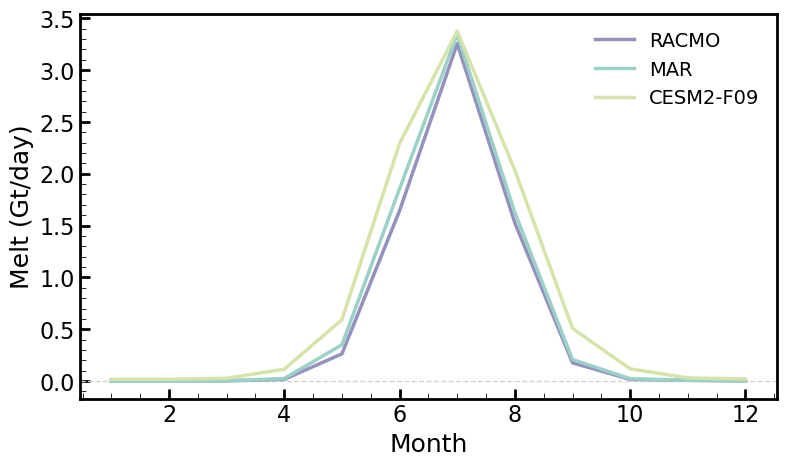

In [17]:
fig = plt.figure(figsize=(9, 5))
gs = GridSpec(1, 1)
plt.rcParams["axes.linewidth"] = 2  # set the value globally

size_title = 18
size_tick = 16
size_label = 18
size_legend = 14
width_line = 2.5
width_box = 1.9

ax1 = plt.subplot(gs[0])

month_in_year = F09_GrIS_melt_monthly_1940_2014_climo.month
plt.axhline(y=0, linestyle="--", color="lightgray", linewidth=1)
ax1.plot(month_in_year, RACMO_GrIS_melt_monthly_1940_2014_climo, color="#9392BE", linewidth=width_line, label="RACMO")#, zorder=5)
ax1.plot(month_in_year, MAR_GrIS_melt_monthly_1940_2014_climo, color="#9CD1C8", linewidth=width_line, label="MAR")
ax1.plot(month_in_year, F09_GrIS_melt_monthly_1940_2014_climo, color="#D5E4A8", linewidth=width_line, label="CESM2-F09")
#D0E7ED
ax1.legend(loc="best", frameon=False, prop={"size": size_legend}, ncol=1)

#ax1.set_xlim([1900, 2014])
#ax1.set_ylim([-15*f09_ocn_area/1e12, 40*f09_ocn_area/1e12])
ax1.set_xlabel("Month", fontsize=size_label)
ax1.set_ylabel("Melt (Gt/day)", fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which="major", length=7, width=2, direction="in")
ax1.tick_params(which="minor", length=4, direction="in")
# ax1.set_yticks([-1000, -500, 0, 500])
ax1.tick_params(labelsize=size_tick)

#plt.savefig(
#    "Figure_S9_v1.png",
#    dpi=300,
#    bbox_inches="tight",
#    facecolor="w",
#    transparent=False,
#)  #

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


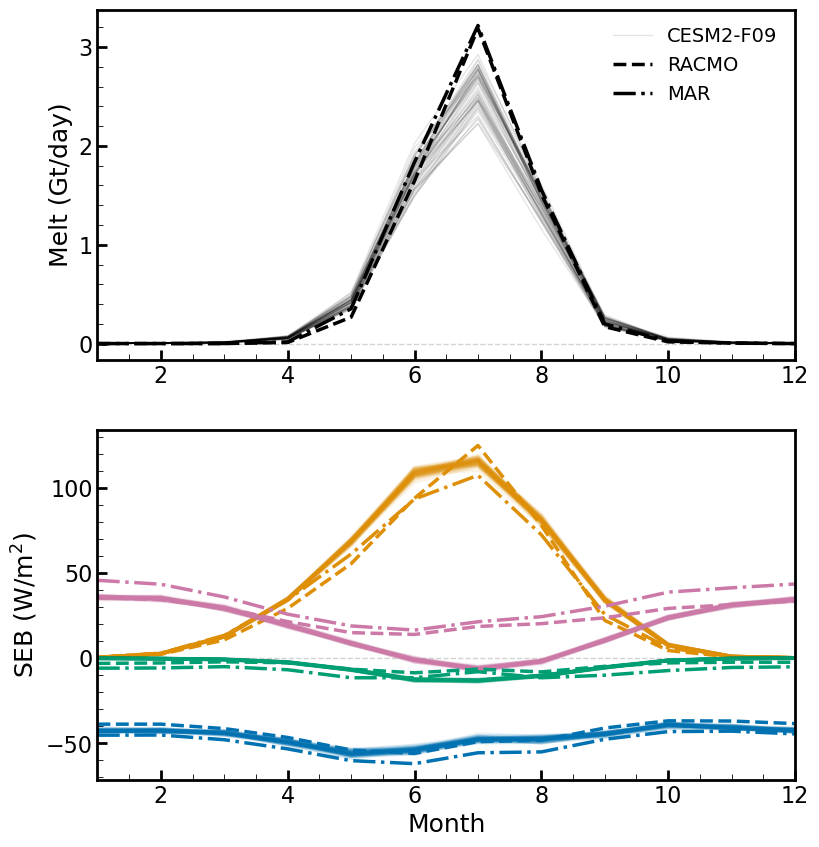

In [51]:
fig = plt.figure(figsize=(9, 10))
gs = GridSpec(2, 1)
plt.rcParams["axes.linewidth"] = 2  # set the value globally

size_title = 18
size_tick = 16
size_label = 18
size_legend = 14
width_line = 2.5
width_box = 1.9

###################################
ax1 = plt.subplot(gs[0])

month_in_year = F09_GrIS_melt_monthly_1940_1969_climo.month
plt.axhline(y=0, linestyle="--", color="lightgray", linewidth=1)
for i in range(50):
    if i == 0:
        ax1.plot(month_in_year, F09_GrIS_melt_monthly_1940_1969_climo.sel(ensemble=i+1), color="black", linewidth=width_line-1.5, alpha=0.1, label="CESM2-F09")
    else:
        ax1.plot(month_in_year, F09_GrIS_melt_monthly_1940_1969_climo.sel(ensemble=i+1), color="black", linewidth=width_line-1.5, alpha=0.1)
ax1.plot(month_in_year, RACMO_GrIS_melt_monthly_1940_1969_climo, color="black", linewidth=width_line, linestyle='--', label="RACMO")
ax1.plot(month_in_year, MAR_GrIS_melt_monthly_1940_1969_climo, color="black", linewidth=width_line, linestyle='-.', label="MAR")
#D0E7ED
ax1.legend(loc="best", frameon=False, prop={"size": size_legend}, ncol=1)

ax1.set_xlim([1, 12])
#ax1.set_ylim([-15*f09_ocn_area/1e12, 40*f09_ocn_area/1e12])
#ax1.set_xlabel("Month", fontsize=size_label)
ax1.set_ylabel("Melt (Gt/day)", fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which="major", length=7, width=2, direction="in")
ax1.tick_params(which="minor", length=4, direction="in")
# ax1.set_yticks([-1000, -500, 0, 500])
ax1.tick_params(labelsize=size_tick)

###################################
ax2 = plt.subplot(gs[1])

plt.axhline(y=0, linestyle="--", color="lightgray", linewidth=1)
for i in range(50):
    ax2.plot(month_in_year, F09_GrIS_SWn_monthly_1940_1969_climo.sel(ensemble=i+1), color="#DE8F05", linewidth=width_line, alpha=0.1)#, label="SWn")
ax2.plot(month_in_year, RACMO_GrIS_SWn_monthly_1940_1969_climo, color="#DE8F05", linewidth=width_line, linestyle='--')
ax2.plot(month_in_year, MAR_GrIS_SWn_monthly_1940_1969_climo, color="#DE8F05", linewidth=width_line, linestyle='-.')

for i in range(50):
    ax2.plot(month_in_year, F09_GrIS_LWn_monthly_1940_1969_climo.sel(ensemble=i+1), color="#0072B2", linewidth=width_line, alpha=0.1)#, label="LWn")
ax2.plot(month_in_year, RACMO_GrIS_LWn_monthly_1940_1969_climo, color="#0072B2", linewidth=width_line, linestyle='--')
ax2.plot(month_in_year, MAR_GrIS_LWn_monthly_1940_1969_climo, color="#0072B2", linewidth=width_line, linestyle='-.')

for i in range(50):
    ax2.plot(month_in_year, F09_GrIS_SH_monthly_1940_1969_climo.sel(ensemble=i+1), color="#CC79A7", linewidth=width_line, alpha=0.1)#, label="SH")
ax2.plot(month_in_year, RACMO_GrIS_SH_monthly_1940_1969_climo, color="#CC79A7", linewidth=width_line, linestyle='--')
ax2.plot(month_in_year, MAR_GrIS_SH_monthly_1940_1969_climo, color="#CC79A7", linewidth=width_line, linestyle='-.')

for i in range(50):
    ax2.plot(month_in_year, F09_GrIS_LH_monthly_1940_1969_climo.sel(ensemble=i+1), color="#009E73", linewidth=width_line, alpha=0.1)#, label="LH")
ax2.plot(month_in_year, RACMO_GrIS_LH_monthly_1940_1969_climo, color="#009E73", linewidth=width_line, linestyle='--')
ax2.plot(month_in_year, MAR_GrIS_LH_monthly_1940_1969_climo, color="#009E73", linewidth=width_line, linestyle='-.')

ax2.legend(loc="best", frameon=False, prop={"size": size_legend}, ncol=1)

ax2.set_xlim([1, 12])
#ax2.set_ylim([-15*f09_ocn_area/1e12, 40*f09_ocn_area/1e12])
ax2.set_xlabel("Month", fontsize=size_label)
ax2.set_ylabel("SEB (W/m$^2$)", fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which="major", length=7, width=2, direction="in")
ax2.tick_params(which="minor", length=4, direction="in")
# ax2.set_yticks([-1000, -500, 0, 500])
ax2.tick_params(labelsize=size_tick)

plt.savefig(
    home_dir+'2023-GrIS-melt-causality/plot/physics/tseries_melt_SEB_seasonal_variation_1940_1969.png',
    dpi=300,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)  #

## Anomaly

### Calculate

In [63]:
## F09
# Stack arrays in sequence vertically (row wise)
F09_GrIS_monthly_1940_1969_anom_climo = np.zeros((50,5,12))

for n in range(50):
    data = np.vstack((
         F09_GrIS_melt_monthly_1940_1969.sel(ensemble=n+1).values, #[Gt/day]
         F09_GrIS_SWn_monthly_1940_1969.sel(ensemble=n+1).values,
         F09_GrIS_LWn_monthly_1940_1969.sel(ensemble=n+1).values,
         F09_GrIS_SH_monthly_1940_1969.sel(ensemble=n+1).values,
         F09_GrIS_LH_monthly_1940_1969.sel(ensemble=n+1).values,
         #F09_int_historical_GHF_monthly.values,
                    )).T
    #T, N = data.shape

    # Smooth-width set to 15 years
    cycle_length = 12   # a year in bi-monthly time resolution 
    smooth_width = 15*cycle_length

    if smooth_width is not None:
        data_here = pp.smooth(data=np.copy(data), smooth_width=smooth_width, kernel='gaussian',
                        residuals=True)
    else:
        data_here = np.copy(data)

    data_here = anomalize(data_here, cycle_length=cycle_length)

    for i in range(5):
        for j in range(12):
            F09_GrIS_monthly_1940_1969_anom_climo[n,i,j] = np.mean(data_here.T[i,j:12:])

In [53]:
## RACMO
# Stack arrays in sequence vertically (row wise)
data = np.vstack((
     RACMO_GrIS_melt_monthly_1940_1969.values, #[Gt/day]
     RACMO_GrIS_SWn_monthly_1940_1969.values,
     RACMO_GrIS_LWn_monthly_1940_1969.values,
     RACMO_GrIS_SH_monthly_1940_1969.values,
     RACMO_GrIS_LH_monthly_1940_1969.values,
     #RACMO_int_historical_GHF_monthly.values,
                )).T
#T, N = data.shape

# Smooth-width set to 15 years
cycle_length = 12   # a year in bi-monthly time resolution 
smooth_width = 15*cycle_length

if smooth_width is not None:
    data_here = pp.smooth(data=np.copy(data), smooth_width=smooth_width, kernel='gaussian',
                    residuals=True)
else:
    data_here = np.copy(data)

data_here = anomalize(data_here, cycle_length=cycle_length)

In [54]:
RACMO_GrIS_monthly_1940_1969_anom_climo = np.zeros((5,12))

for i in range(5):
    for j in range(12):
        RACMO_GrIS_monthly_1940_1969_anom_climo[i,j] = np.mean(data_here.T[i,j:12:])

In [55]:
## MAR
# Stack arrays in sequence vertically (row wise)
data = np.vstack((
     MAR_GrIS_melt_monthly_1940_1969.values, #[Gt/day]
     MAR_GrIS_SWn_monthly_1940_1969.values,
     MAR_GrIS_LWn_monthly_1940_1969.values,
     MAR_GrIS_SH_monthly_1940_1969.values,
     MAR_GrIS_LH_monthly_1940_1969.values,
     #MAR_int_historical_GHF_monthly.values,
                )).T
#T, N = data.shape

# Smooth-width set to 15 years
cycle_length = 12   # a year in bi-monthly time resolution 
smooth_width = 15*cycle_length

if smooth_width is not None:
    data_here = pp.smooth(data=np.copy(data), smooth_width=smooth_width, kernel='gaussian',
                    residuals=True)
else:
    data_here = np.copy(data)

data_here = anomalize(data_here, cycle_length=cycle_length)

In [56]:
MAR_GrIS_monthly_1940_1969_anom_climo = np.zeros((5,12))

for i in range(5):
    for j in range(12):
        MAR_GrIS_monthly_1940_1969_anom_climo[i,j] = np.mean(data_here.T[i,j:12:])

### Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


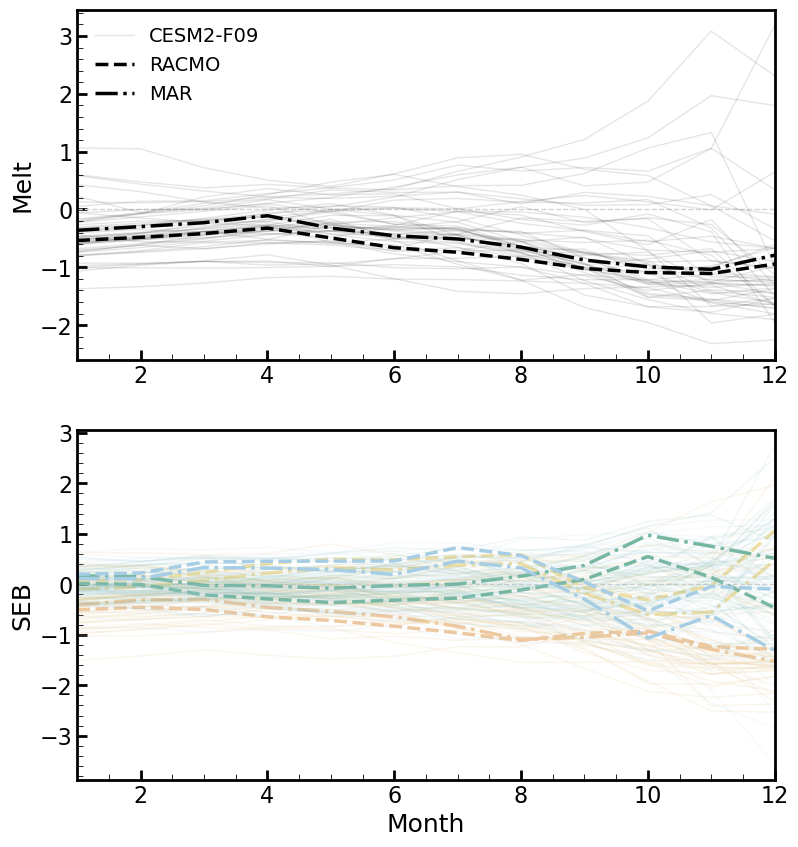

In [65]:
fig = plt.figure(figsize=(9, 10))
gs = GridSpec(2, 1)
plt.rcParams["axes.linewidth"] = 2  # set the value globally

size_title = 18
size_tick = 16
size_label = 18
size_legend = 14
width_line = 2.5
width_box = 1.9

###################################
ax1 = plt.subplot(gs[0])

month_in_year = F09_GrIS_melt_monthly_1940_1969_climo.month
plt.axhline(y=0, linestyle="--", color="lightgray", linewidth=1)
for i in range(50):
    if i == 0:
        ax1.plot(month_in_year, F09_GrIS_monthly_1940_1969_anom_climo[i,0], color="black", linewidth=width_line-1.5, alpha=0.1, label="CESM2-F09")
    else:
        ax1.plot(month_in_year, F09_GrIS_monthly_1940_1969_anom_climo[i,0], color="black", linewidth=width_line-1.5, alpha=0.1)
ax1.plot(month_in_year, RACMO_GrIS_monthly_1940_1969_anom_climo[0], color="black", linewidth=width_line, linestyle='--', label="RACMO")
ax1.plot(month_in_year, MAR_GrIS_monthly_1940_1969_anom_climo[0], color="black", linewidth=width_line, linestyle='-.', label="MAR")
#D0E7ED
ax1.legend(loc="best", frameon=False, prop={"size": size_legend}, ncol=1)

ax1.set_xlim([1, 12])
#ax1.set_ylim([-15*f09_ocn_area/1e12, 40*f09_ocn_area/1e12])
#ax1.set_xlabel("Month", fontsize=size_label)
ax1.set_ylabel("Melt", fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which="major", length=7, width=2, direction="in")
ax1.tick_params(which="minor", length=4, direction="in")
# ax1.set_yticks([-1000, -500, 0, 500])
ax1.tick_params(labelsize=size_tick)

###################################
ax2 = plt.subplot(gs[1])

plt.axhline(y=0, linestyle="--", color="lightgray", linewidth=1)
for i in range(50):
    ax2.plot(month_in_year, F09_GrIS_monthly_1940_1969_anom_climo[i,1], color="#EEC79F", linewidth=width_line-1.5, alpha=0.1)# label="SWn")
ax2.plot(month_in_year, RACMO_GrIS_monthly_1940_1969_anom_climo[1], color="#EEC79F", linewidth=width_line, linestyle='--')
ax2.plot(month_in_year, MAR_GrIS_monthly_1940_1969_anom_climo[1], color="#EEC79F", linewidth=width_line, linestyle='-.')

for i in range(50):
    ax2.plot(month_in_year, F09_GrIS_monthly_1940_1969_anom_climo[i,1], color="#F1DFA4", linewidth=width_line-1.5, alpha=0.1)# label="LWn")
ax2.plot(month_in_year, RACMO_GrIS_monthly_1940_1969_anom_climo[2], color="#F1DFA4", linewidth=width_line, linestyle='--')
ax2.plot(month_in_year, MAR_GrIS_monthly_1940_1969_anom_climo[2], color="#F1DFA4", linewidth=width_line, linestyle='-.')

for i in range(50):
    ax2.plot(month_in_year, F09_GrIS_monthly_1940_1969_anom_climo[i,3], color="#74B69F", linewidth=width_line-1.5, alpha=0.1)# label="SH")
ax2.plot(month_in_year, RACMO_GrIS_monthly_1940_1969_anom_climo[3], color="#74B69F", linewidth=width_line, linestyle='--')
ax2.plot(month_in_year, MAR_GrIS_monthly_1940_1969_anom_climo[3], color="#74B69F", linewidth=width_line, linestyle='-.')

for i in range(50):
    ax2.plot(month_in_year, F09_GrIS_monthly_1940_1969_anom_climo[i,4], color="#A6CDE4", linewidth=width_line-1.5, alpha=0.1)# label="LH")
ax2.plot(month_in_year, RACMO_GrIS_monthly_1940_1969_anom_climo[4], color="#A6CDE4", linewidth=width_line, linestyle='--')
ax2.plot(month_in_year, MAR_GrIS_monthly_1940_1969_anom_climo[4], color="#A6CDE4", linewidth=width_line, linestyle='-.')

ax2.legend(loc="best", frameon=False, prop={"size": size_legend}, ncol=1)

ax2.set_xlim([1, 12])
#ax2.set_ylim([-15*f09_ocn_area/1e12, 40*f09_ocn_area/1e12])
ax2.set_xlabel("Month", fontsize=size_label)
ax2.set_ylabel("SEB", fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which="major", length=7, width=2, direction="in")
ax2.tick_params(which="minor", length=4, direction="in")
# ax2.set_yticks([-1000, -500, 0, 500])
ax2.tick_params(labelsize=size_tick)

plt.savefig(
    home_dir+'2023-GrIS-melt-causality/plot/physics/tseries_melt_SEB_anom_seasonal_variation_1940_1969.png',
    dpi=300,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)  #

## Select the 10 largest melt years

### Calculate

In [136]:
year = RACMO_GrIS_melt_monthly_1940_2014.date.dt.year
days_in_month = RACMO_GrIS_melt_monthly_1940_2014.date.dt.days_in_month

RACMO_GrIS_melt_yearly_1940_2014 = (RACMO_GrIS_melt_monthly_1940_2014 * days_in_month).groupby(year).sum() #[Gt/yr]
MAR_GrIS_melt_yearly_1940_2014 = (MAR_GrIS_melt_monthly_1940_2014 * days_in_month).groupby(year).sum() #[Gt/yr]
F09_GrIS_melt_yearly_1940_2014 = (F09_GrIS_melt_monthly_1940_2014 * days_in_month).groupby(year).sum() #[Gt/yr]

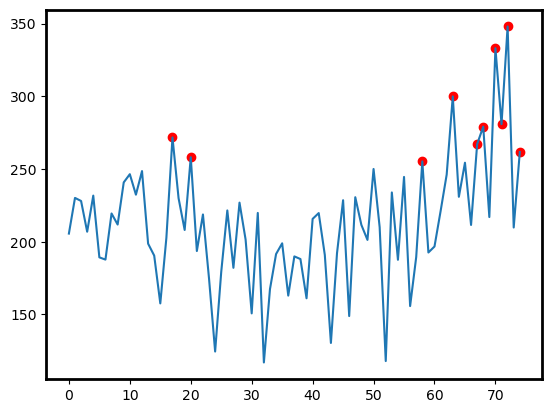

In [100]:
# RACMO, MAR, and CESM2-F09 don't agree on the top 10 melt years
plt.plot(np.arange(len(RACMO_GrIS_melt_yearly_1940_2014)), RACMO_GrIS_melt_yearly_1940_2014);
plt.scatter(np.arange(len(RACMO_GrIS_melt_yearly_1940_2014)), RACMO_GrIS_melt_yearly_1940_2014.where(RACMO_GrIS_melt_yearly_1940_2014>255), color='red')

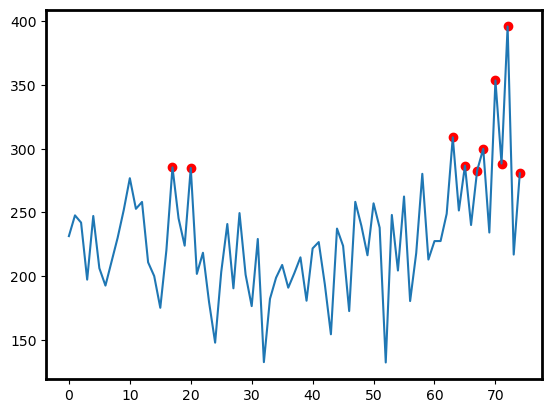

In [148]:
plt.plot(np.arange(len(MAR_GrIS_melt_yearly_1940_2014)), MAR_GrIS_melt_yearly_1940_2014);
plt.scatter(np.arange(len(MAR_GrIS_melt_yearly_1940_2014)), MAR_GrIS_melt_yearly_1940_2014.where(MAR_GrIS_melt_yearly_1940_2014>280.5), color='red')

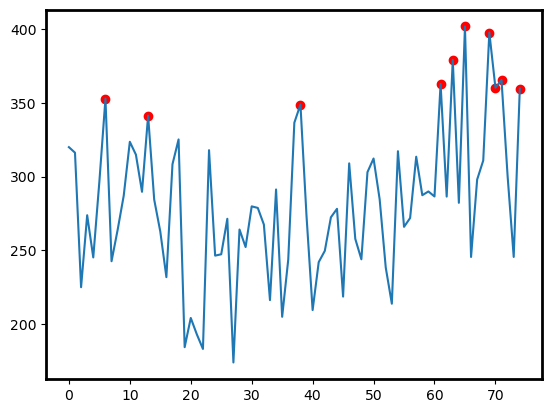

In [151]:

plt.plot(np.arange(len(F09_GrIS_melt_yearly_1940_2014)), F09_GrIS_melt_yearly_1940_2014);
plt.scatter(np.arange(len(F09_GrIS_melt_yearly_1940_2014)), F09_GrIS_melt_yearly_1940_2014.where(F09_GrIS_melt_yearly_1940_2014>340), color='red')

In [152]:
year_topmelt_RACMO = year[::12].where(RACMO_GrIS_melt_yearly_1940_2014.values>255).dropna(dim='date').values.tolist()
year_topmelt_RACMO = [round(x) for x in year_topmelt_RACMO]
print(year_topmelt_RACMO)

year_topmelt_MAR = year[::12].where(MAR_GrIS_melt_yearly_1940_2014.values>280.5).dropna(dim='date').values.tolist()
year_topmelt_MAR = [round(x) for x in year_topmelt_MAR]
print(year_topmelt_MAR)

year_topmelt_F09 = year[::12].where(F09_GrIS_melt_yearly_1940_2014.values>340).dropna(dim='date').values.tolist()
year_topmelt_F09 = [round(x) for x in year_topmelt_F09]
print(year_topmelt_F09)

[1957, 1960, 1998, 2003, 2007, 2008, 2010, 2011, 2012, 2014]
[1957, 1960, 2003, 2005, 2007, 2008, 2010, 2011, 2012, 2014]
[1946, 1953, 1978, 2001, 2003, 2005, 2009, 2010, 2011, 2014]


In [153]:
# Monthly climatology
month = F09_GrIS_melt_monthly_1940_2014.date.dt.month

RACMO_GrIS_melt_monthly_1940_2014_topmelt_climo = RACMO_GrIS_melt_monthly_1940_2014.where(year.isin(year_topmelt_RACMO)).groupby(month).mean()
RACMO_GrIS_SWn_monthly_1940_2014_topmelt_climo = RACMO_GrIS_SWn_monthly_1940_2014.where(year.isin(year_topmelt_RACMO)).groupby(month).mean()
RACMO_GrIS_LWn_monthly_1940_2014_topmelt_climo = RACMO_GrIS_LWn_monthly_1940_2014.where(year.isin(year_topmelt_RACMO)).groupby(month).mean()
RACMO_GrIS_SH_monthly_1940_2014_topmelt_climo = RACMO_GrIS_SH_monthly_1940_2014.where(year.isin(year_topmelt_RACMO)).groupby(month).mean()
RACMO_GrIS_LH_monthly_1940_2014_topmelt_climo = RACMO_GrIS_LH_monthly_1940_2014.where(year.isin(year_topmelt_RACMO)).groupby(month).mean()

MAR_GrIS_melt_monthly_1940_2014_topmelt_climo = MAR_GrIS_melt_monthly_1940_2014.where(year.isin(year_topmelt_MAR)).groupby(month).mean()
MAR_GrIS_SWn_monthly_1940_2014_topmelt_climo = MAR_GrIS_SWn_monthly_1940_2014.where(year.isin(year_topmelt_MAR)).groupby(month).mean()
MAR_GrIS_LWn_monthly_1940_2014_topmelt_climo = MAR_GrIS_LWn_monthly_1940_2014.where(year.isin(year_topmelt_MAR)).groupby(month).mean()
MAR_GrIS_SH_monthly_1940_2014_topmelt_climo = MAR_GrIS_SH_monthly_1940_2014.where(year.isin(year_topmelt_MAR)).groupby(month).mean()
MAR_GrIS_LH_monthly_1940_2014_topmelt_climo = MAR_GrIS_LH_monthly_1940_2014.where(year.isin(year_topmelt_MAR)).groupby(month).mean()

F09_GrIS_melt_monthly_1940_2014_topmelt_climo = F09_GrIS_melt_monthly_1940_2014.where(year.isin(year_topmelt_F09)).groupby(month).mean()
F09_GrIS_SWn_monthly_1940_2014_topmelt_climo = F09_GrIS_SWn_monthly_1940_2014.where(year.isin(year_topmelt_F09)).groupby(month).mean()
F09_GrIS_LWn_monthly_1940_2014_topmelt_climo = F09_GrIS_LWn_monthly_1940_2014.where(year.isin(year_topmelt_F09)).groupby(month).mean()
F09_GrIS_SH_monthly_1940_2014_topmelt_climo = F09_GrIS_SH_monthly_1940_2014.where(year.isin(year_topmelt_F09)).groupby(month).mean()
F09_GrIS_LH_monthly_1940_2014_topmelt_climo = F09_GrIS_LH_monthly_1940_2014.where(year.isin(year_topmelt_F09)).groupby(month).mean()

### Plot

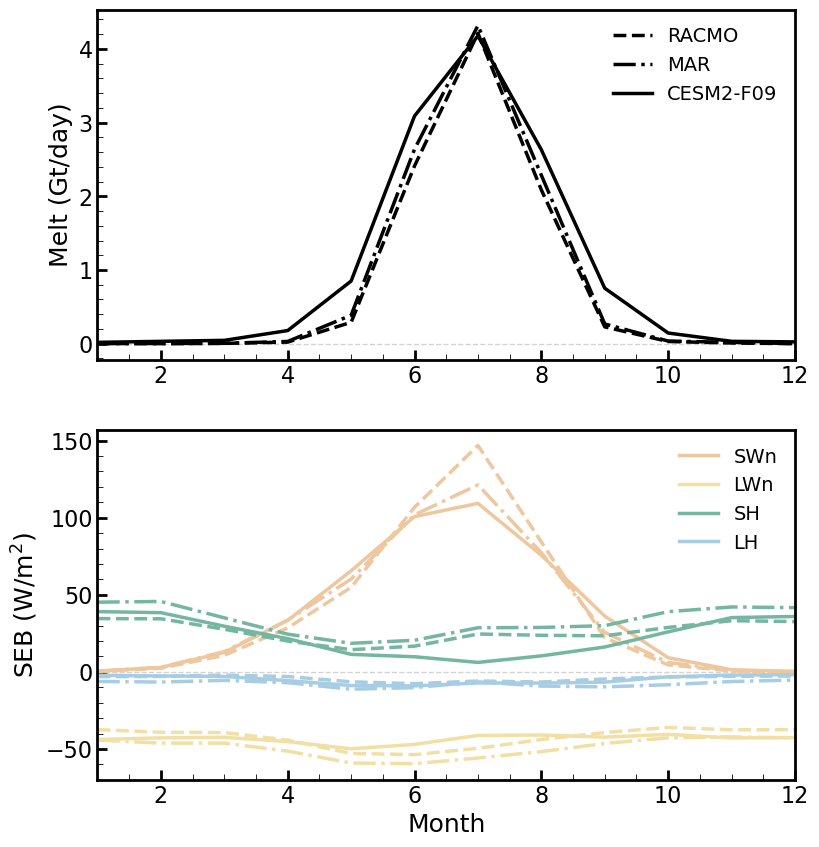

In [154]:
fig = plt.figure(figsize=(9, 10))
gs = GridSpec(2, 1)
plt.rcParams["axes.linewidth"] = 2  # set the value globally

size_title = 18
size_tick = 16
size_label = 18
size_legend = 14
width_line = 2.5
width_box = 1.9

###################################
ax1 = plt.subplot(gs[0])

month_in_year = F09_GrIS_melt_monthly_1940_2014_climo.month
plt.axhline(y=0, linestyle="--", color="lightgray", linewidth=1)
ax1.plot(month_in_year, RACMO_GrIS_melt_monthly_1940_2014_topmelt_climo, color="black", linewidth=width_line, linestyle='--', label="RACMO")
ax1.plot(month_in_year, MAR_GrIS_melt_monthly_1940_2014_topmelt_climo, color="black", linewidth=width_line, linestyle='-.', label="MAR")
ax1.plot(month_in_year, F09_GrIS_melt_monthly_1940_2014_topmelt_climo, color="black", linewidth=width_line, label="CESM2-F09")
#D0E7ED
ax1.legend(loc="best", frameon=False, prop={"size": size_legend}, ncol=1)

ax1.set_xlim([1, 12])
#ax1.set_ylim([-15*f09_ocn_area/1e12, 40*f09_ocn_area/1e12])
#ax1.set_xlabel("Month", fontsize=size_label)
ax1.set_ylabel("Melt (Gt/day)", fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which="major", length=7, width=2, direction="in")
ax1.tick_params(which="minor", length=4, direction="in")
# ax1.set_yticks([-1000, -500, 0, 500])
ax1.tick_params(labelsize=size_tick)

###################################
ax2 = plt.subplot(gs[1])

plt.axhline(y=0, linestyle="--", color="lightgray", linewidth=1)
ax2.plot(month_in_year, RACMO_GrIS_SWn_monthly_1940_2014_topmelt_climo, color="#EEC79F", linewidth=width_line, linestyle='--')
ax2.plot(month_in_year, MAR_GrIS_SWn_monthly_1940_2014_topmelt_climo, color="#EEC79F", linewidth=width_line, linestyle='-.')
ax2.plot(month_in_year, F09_GrIS_SWn_monthly_1940_2014_topmelt_climo, color="#EEC79F", linewidth=width_line, label="SWn")

ax2.plot(month_in_year, RACMO_GrIS_LWn_monthly_1940_2014_topmelt_climo, color="#F1DFA4", linewidth=width_line, linestyle='--')
ax2.plot(month_in_year, MAR_GrIS_LWn_monthly_1940_2014_topmelt_climo, color="#F1DFA4", linewidth=width_line, linestyle='-.')
ax2.plot(month_in_year, F09_GrIS_LWn_monthly_1940_2014_topmelt_climo, color="#F1DFA4", linewidth=width_line, label="LWn")

ax2.plot(month_in_year, RACMO_GrIS_SH_monthly_1940_2014_topmelt_climo, color="#74B69F", linewidth=width_line, linestyle='--')
ax2.plot(month_in_year, MAR_GrIS_SH_monthly_1940_2014_topmelt_climo, color="#74B69F", linewidth=width_line, linestyle='-.')
ax2.plot(month_in_year, F09_GrIS_SH_monthly_1940_2014_topmelt_climo, color="#74B69F", linewidth=width_line, label="SH")

ax2.plot(month_in_year, RACMO_GrIS_LH_monthly_1940_2014_topmelt_climo, color="#A6CDE4", linewidth=width_line, linestyle='--')
ax2.plot(month_in_year, MAR_GrIS_LH_monthly_1940_2014_topmelt_climo, color="#A6CDE4", linewidth=width_line, linestyle='-.')
ax2.plot(month_in_year, F09_GrIS_LH_monthly_1940_2014_topmelt_climo, color="#A6CDE4", linewidth=width_line, label="LH")

ax2.legend(loc="best", frameon=False, prop={"size": size_legend}, ncol=1)

ax2.set_xlim([1, 12])
#ax2.set_ylim([-15*f09_ocn_area/1e12, 40*f09_ocn_area/1e12])
ax2.set_xlabel("Month", fontsize=size_label)
ax2.set_ylabel("SEB (W/m$^2$)", fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which="major", length=7, width=2, direction="in")
ax2.tick_params(which="minor", length=4, direction="in")
# ax2.set_yticks([-1000, -500, 0, 500])
ax2.tick_params(labelsize=size_tick)

plt.savefig(
    home_dir+'GrIS_melt_causality/plot/physics/tseries_melt_SEB_seasonal_variation_hist_top10melt.png',
    dpi=300,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)  #

## Lagged correlation

### Original time series

In [39]:
# CESM2-F09
F09_melt = F09_GrIS_melt_monthly_1940_2014
F09_SWn = F09_GrIS_SWn_monthly_1940_2014
F09_LWn = F09_GrIS_LWn_monthly_1940_2014
F09_SH = F09_GrIS_SH_monthly_1940_2014
F09_LH = F09_GrIS_LH_monthly_1940_2014

# RACMO
RACMO_melt = RACMO_GrIS_melt_monthly_1940_2014
RACMO_SWn = RACMO_GrIS_SWn_monthly_1940_2014
RACMO_LWn = RACMO_GrIS_LWn_monthly_1940_2014
RACMO_SH = RACMO_GrIS_SH_monthly_1940_2014
RACMO_LH = RACMO_GrIS_LH_monthly_1940_2014

# MAR
MAR_melt = MAR_GrIS_melt_monthly_1940_2014
MAR_SWn = MAR_GrIS_SWn_monthly_1940_2014
MAR_LWn = MAR_GrIS_LWn_monthly_1940_2014
MAR_SH = MAR_GrIS_SH_monthly_1940_2014
MAR_LH = MAR_GrIS_LH_monthly_1940_2014

In [40]:
# === Organize the data ===
models = {
    'CESM2-F09': [F09_melt, F09_SWn, F09_LWn, F09_SH, F09_LH],
    'RACMO': [RACMO_melt, RACMO_SWn, RACMO_LWn, RACMO_SH, RACMO_LH],
    'MAR': [MAR_melt, MAR_SWn, MAR_LWn, MAR_SH, MAR_LH]
}

variables = ['Melt', 'SWn', 'LWn', 'SH', 'LH']
lags = np.arange(-12, 13)  # -12 to 12 months

# === Custom function to construct JJA melt and lagged predictors ===
def extract_shifted_JJA(melt, var, lag):
    n_months = melt.shape[0]
    n_years = n_months // 12
    melt_JJA = []
    var_shifted = []
    for i in range(n_years):
        year_start = i * 12
        for j, month in enumerate([5, 6, 7]):  # June (5), July (6), August (7)
            melt_idx = year_start + month
            var_idx = melt_idx + lag
            if 0 <= var_idx < n_months and 0 <= melt_idx < n_months:
                melt_JJA.append(melt.values[melt_idx])
                var_shifted.append(var.values[var_idx])
    return np.array(melt_JJA), np.array(var_shifted)

# === Calculate lagged correlations ===
correlations = {model: {var: [] for var in variables} for model in models.keys()}

for model_name, (melt, SWn, LWn, SH, LH) in models.items():
    for var_name, var in zip(variables, [melt, SWn, LWn, SH, LH]):
        for lag in lags:
            melt_JJA, var_shifted = extract_shifted_JJA(melt, var, lag)
            if len(melt_JJA) > 0:
                corr, _ = pearsonr(var_shifted, melt_JJA)
                correlations[model_name][var_name].append(corr)
            else:
                correlations[model_name][var_name].append(np.nan)

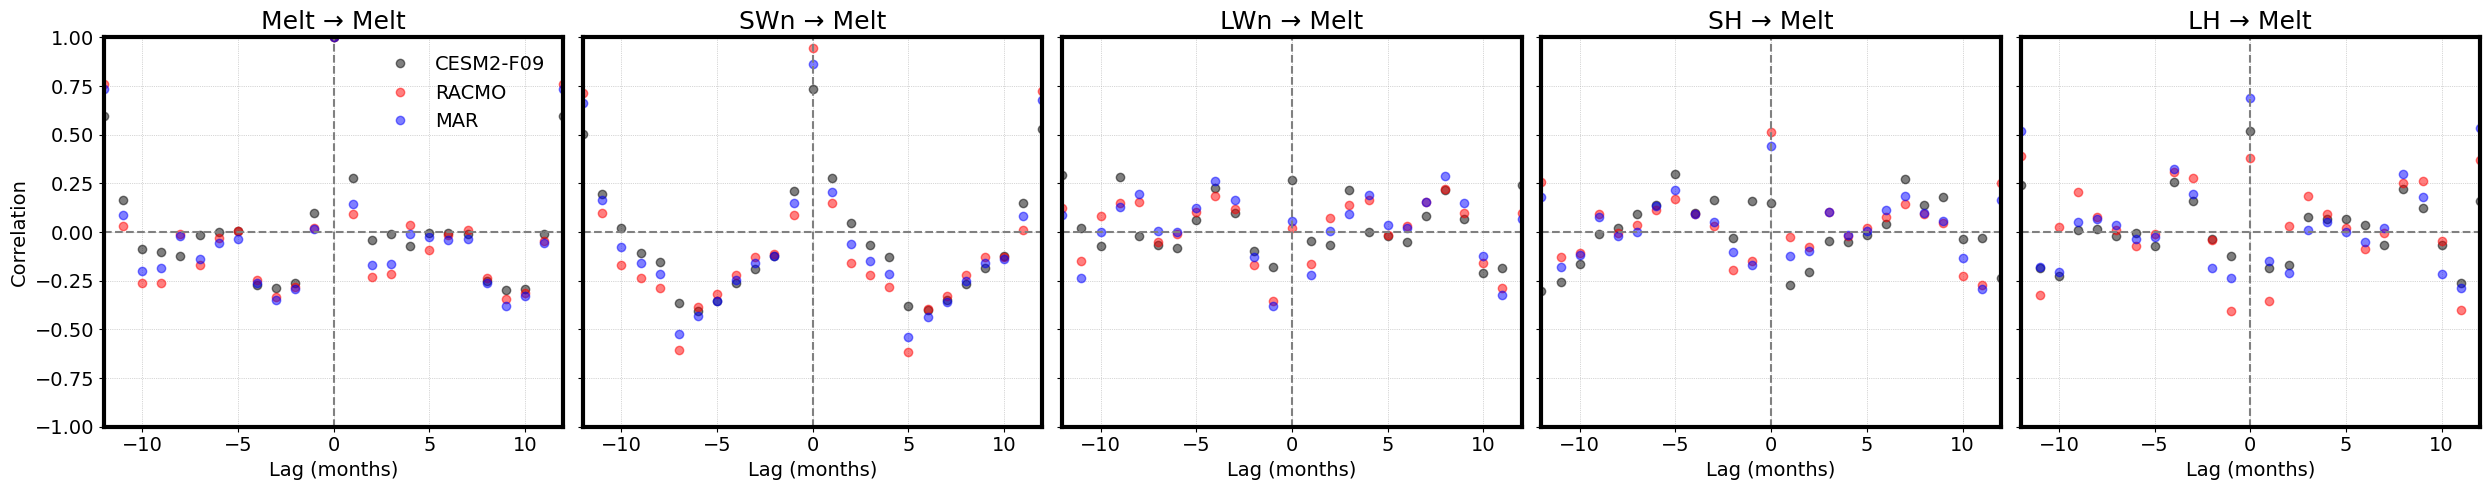

In [41]:
# === Plotting ===
fig, axs = plt.subplots(1, 5, figsize=(25, 5), sharey=True)
plt.rcParams["axes.linewidth"] = 3  # set the value globally

colors = {
    'CESM2-F09': 'black',
    'RACMO': 'red',
    'MAR': 'blue'
}

size_legend = 14
size_label = 14
size_title = 18
size_tick = 14

for idx, var in enumerate(variables):
    ax = axs[idx]
    for model_name in models.keys():
        ax.plot(lags, correlations[model_name][var], marker='o', linestyle='None', label=model_name, color=colors[model_name], alpha=0.5)
    ax.set_title(f'{var} → Melt', size=size_title)
    ax.set_xlabel('Lag (months)', size=size_label)
    if idx == 0:
        ax.set_ylabel('Correlation', size=size_label)
    ax.axhline(0, color='gray', linestyle='--')
    ax.axvline(0, color='gray', linestyle='--')
    ax.set_xlim(-12, 12)
    ax.set_ylim(-1, 1)
    ax.grid(True, linestyle=':', linewidth=0.5)
    #ax.xaxis.set_minor_locator(AutoMinorLocator())
    #ax.yaxis.set_minor_locator(AutoMinorLocator())
    #ax.tick_params(which="major", length=7, width=2, direction="in")
    #ax.tick_params(which="minor", length=4, direction="in")
    ax.tick_params(labelsize=size_tick)

axs[0].legend(loc="best", frameon=False, prop={"size": size_legend}, ncol=1)

plt.tight_layout()
plt.savefig(
    home_dir+'2023-GrIS-melt-causality/plot/physics/lagged_cor_melt_SEB_hist.png',
    dpi=300,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)

### Anomaly

In [7]:
def process_prepare_lagcor(int_vars, remove_seasonal_cycle=False):

    # Stack arrays in sequence vertically (row wise)
    data = np.vstack((
        int_vars['Melt'].values,
        int_vars['SWn'].values,
        int_vars['LWn'].values,
        int_vars['SH'].values,
        int_vars['LH'].values,
                    )).T
    T, N = data.shape

    # Variable names used throughout
    var_names = ['Melt', 'SWn', 'LWn', 'SH', 'LH']

    # Smooth-width set to 15 years
    cycle_length = 12   # a year in monthly time resolution
    smooth_width = 15*cycle_length

    if smooth_width is not None:
        smoothdata_here = pp.smooth(np.copy(data), smooth_width=smooth_width, kernel='gaussian', # the low-frequency variability including the long-term trend
                        residuals=False)
        data_here = pp.smooth(np.copy(data), smooth_width=smooth_width, kernel='gaussian', # the detrended residuals or high-frequency variability
                        residuals=True)
    else:
        print("Not smoothed.")
        data_here = np.copy(data)

    # Remove seasonal mean and divide by seasonal standard deviation
    seasonal_cycle = anomalize(np.copy(data_here), cycle_length=cycle_length, return_cycle=True)
    smoothdata_here += seasonal_cycle # the sum of low-frequency variability and seasonal cycle
    if remove_seasonal_cycle == True:
        data_here = anomalize(data_here, cycle_length=cycle_length)

    return data_here

In [16]:
LENS2_GrIS_monthly_1940_1969_anom = np.zeros((50,5,30*12))

In [17]:
for n in range(1,51):
    int_vars = xr.open_dataset(LENS2_file).sel(ensemble=n).sel(time=slice('1940-01-01','1969-12-31'))

    LENS2_GrIS_monthly_1940_1969_anom[n-1] = process_prepare_lagcor(int_vars, remove_seasonal_cycle=True).T

In [ ]:
## F09
# Stack arrays in sequence vertically (row wise)
data = np.vstack((
     F09_GrIS_melt_monthly_1940_2014.values, #[Gt/day]
     F09_GrIS_SWn_monthly_1940_2014.values,
     F09_GrIS_LWn_monthly_1940_2014.values,
     F09_GrIS_SH_monthly_1940_2014.values,
     F09_GrIS_LH_monthly_1940_2014.values,
     #F09_int_historical_GHF_monthly.values,
                )).T
#T, N = data.shape

# Smooth-width set to 15 years
cycle_length = 12   # a year in bi-monthly time resolution 
smooth_width = 15*cycle_length

if smooth_width is not None:
    data_here = pp.smooth(data=np.copy(data), smooth_width=smooth_width, kernel='gaussian',
                    residuals=True)
else:
    data_here = np.copy(data)

F09_GrIS_monthly_1940_2014_anom = anomalize(data_here, cycle_length=cycle_length).T

In [18]:
## RACMO
# Stack arrays in sequence vertically (row wise)
data = np.vstack((
     RACMO_GrIS_melt_monthly_1940_1969.values, #[Gt/day]
     RACMO_GrIS_SWn_monthly_1940_1969.values,
     RACMO_GrIS_LWn_monthly_1940_1969.values,
     RACMO_GrIS_SH_monthly_1940_1969.values,
     RACMO_GrIS_LH_monthly_1940_1969.values,
     #RACMO_int_historical_GHF_monthly.values,
                )).T
#T, N = data.shape

# Smooth-width set to 15 years
cycle_length = 12   # a year in bi-monthly time resolution 
smooth_width = 15*cycle_length

if smooth_width is not None:
    data_here = pp.smooth(data=np.copy(data), smooth_width=smooth_width, kernel='gaussian',
                    residuals=True)
else:
    data_here = np.copy(data)

RACMO_GrIS_monthly_1940_1969_anom = anomalize(data_here, cycle_length=cycle_length).T

In [19]:
## MAR
# Stack arrays in sequence vertically (row wise)
data = np.vstack((
     MAR_GrIS_melt_monthly_1940_1969.values, #[Gt/day]
     MAR_GrIS_SWn_monthly_1940_1969.values,
     MAR_GrIS_LWn_monthly_1940_1969.values,
     MAR_GrIS_SH_monthly_1940_1969.values,
     MAR_GrIS_LH_monthly_1940_1969.values,
     #MAR_int_historical_GHF_monthly.values,
                )).T
#T, N = data.shape

# Smooth-width set to 15 years
cycle_length = 12   # a year in bi-monthly time resolution 
smooth_width = 15*cycle_length

if smooth_width is not None:
    data_here = pp.smooth(data=np.copy(data), smooth_width=smooth_width, kernel='gaussian',
                    residuals=True)
else:
    data_here = np.copy(data)

MAR_GrIS_monthly_1940_1969_anom = anomalize(data_here, cycle_length=cycle_length).T

In [46]:
# CESM2-F09
F09_melt = F09_GrIS_monthly_1940_2014_anom[0]
F09_SWn = F09_GrIS_monthly_1940_2014_anom[1]
F09_LWn = F09_GrIS_monthly_1940_2014_anom[2]
F09_SH = F09_GrIS_monthly_1940_2014_anom[3]
F09_LH = F09_GrIS_monthly_1940_2014_anom[4]

# RACMO
RACMO_melt = RACMO_GrIS_monthly_1940_1969_anom[0]
RACMO_SWn = RACMO_GrIS_monthly_1940_1969_anom[1]
RACMO_LWn = RACMO_GrIS_monthly_1940_1969_anom[2]
RACMO_SH = RACMO_GrIS_monthly_1940_1969_anom[3]
RACMO_LH = RACMO_GrIS_monthly_1940_1969_anom[4]

# MAR
MAR_melt = MAR_GrIS_monthly_1940_1969_anom[0]
MAR_SWn = MAR_GrIS_monthly_1940_1969_anom[1]
MAR_LWn = MAR_GrIS_monthly_1940_1969_anom[2]
MAR_SH = MAR_GrIS_monthly_1940_1969_anom[3]
MAR_LH = MAR_GrIS_monthly_1940_1969_anom[4]

In [20]:
# CESM2-F09
F09_melt = LENS2_GrIS_monthly_1940_1969_anom[:,0,:]
F09_SWn = LENS2_GrIS_monthly_1940_1969_anom[:,1,:]
F09_LWn = LENS2_GrIS_monthly_1940_1969_anom[:,2,:]
F09_SH = LENS2_GrIS_monthly_1940_1969_anom[:,3,:]
F09_LH = LENS2_GrIS_monthly_1940_1969_anom[:,4,:]

# RACMO
RACMO_melt = RACMO_GrIS_monthly_1940_1969_anom[0]
RACMO_SWn = RACMO_GrIS_monthly_1940_1969_anom[1]
RACMO_LWn = RACMO_GrIS_monthly_1940_1969_anom[2]
RACMO_SH = RACMO_GrIS_monthly_1940_1969_anom[3]
RACMO_LH = RACMO_GrIS_monthly_1940_1969_anom[4]

# MAR
MAR_melt = MAR_GrIS_monthly_1940_1969_anom[0]
MAR_SWn = MAR_GrIS_monthly_1940_1969_anom[1]
MAR_LWn = MAR_GrIS_monthly_1940_1969_anom[2]
MAR_SH = MAR_GrIS_monthly_1940_1969_anom[3]
MAR_LH = MAR_GrIS_monthly_1940_1969_anom[4]

#### Variance

In [21]:
# RACMO
# Sample variance (N-1 in denominator)
RACMO_melt_variance = np.var(RACMO_melt, ddof=1)
RACMO_SWn_variance = np.var(RACMO_SWn, ddof=1)
RACMO_LWn_variance = np.var(RACMO_LWn, ddof=1)
RACMO_SH_variance = np.var(RACMO_SH, ddof=1)
RACMO_LH_variance = np.var(RACMO_LH, ddof=1)

print("melt variance: ", RACMO_melt_variance)
print("SWn variance: ", RACMO_SWn_variance)
print("LWn variance: ", RACMO_LWn_variance)
print("SH variance: ", RACMO_SH_variance)
print("LH variance: ", RACMO_LH_variance)

melt variance:  1.0027855153203342
SWn variance:  1.0027855153203342
LWn variance:  1.0027855153203342
SH variance:  1.0027855153203342
LH variance:  1.0027855153203342


In [22]:
# MAR
# Sample variance (N-1 in denominator)
MAR_melt_variance = np.var(MAR_melt, ddof=1)
MAR_SWn_variance = np.var(MAR_SWn, ddof=1)
MAR_LWn_variance = np.var(MAR_LWn, ddof=1)
MAR_SH_variance = np.var(MAR_SH, ddof=1)
MAR_LH_variance = np.var(MAR_LH, ddof=1)

print("melt variance: ", MAR_melt_variance)
print("SWn variance: ", MAR_SWn_variance)
print("LWn variance: ", MAR_LWn_variance)
print("SH variance: ", MAR_SH_variance)
print("LH variance: ", MAR_LH_variance)

melt variance:  1.0027855153203344
SWn variance:  1.0027855153203342
LWn variance:  1.0027855153203342
SH variance:  1.0027855153203342
LH variance:  1.0027855153203344


In [20]:
# Example time series
x = np.array([3, 5, 2, 7, 2])

# Sample variance (N-1 in denominator)
variance = np.var(x, ddof=1)
print(variance)

4.7


#### Without significance level

In [35]:
# === Organize the data ===
models = {
    'CESM2-F09': [F09_melt, F09_SWn, F09_LWn, F09_SH, F09_LH],
    'RACMO': [RACMO_melt, RACMO_SWn, RACMO_LWn, RACMO_SH, RACMO_LH],
    'MAR': [MAR_melt, MAR_SWn, MAR_LWn, MAR_SH, MAR_LH]
}

variables = ['Melt', 'SWn', 'LWn', 'SH', 'LH']
lags = np.arange(-12, 13)  # -12 to 12 months

# === Custom function to construct JJA melt and lagged predictors ===
def extract_shifted_JJA(melt, var, lag):
    n_months = melt.shape[0]
    n_years = n_months // 12
    melt_JJA = []
    var_shifted = []
    for i in range(n_years):
        year_start = i * 12
        for j, month in enumerate([5, 6, 7]):  # June (5), July (6), August (7)
            melt_idx = year_start + month
            var_idx = melt_idx + lag
            if 0 <= var_idx < n_months and 0 <= melt_idx < n_months:
                melt_JJA.append(melt[melt_idx])
                var_shifted.append(var[var_idx])
    return np.array(melt_JJA), np.array(var_shifted)

# === Calculate lagged correlations ===
correlations = {model: {var: [] for var in variables} for model in models.keys()}

for model_name, (melt, SWn, LWn, SH, LH) in models.items():
    for var_name, var in zip(variables, [melt, SWn, LWn, SH, LH]):
        for lag in lags:
            melt_JJA, var_shifted = extract_shifted_JJA(melt, var, lag)
            if len(melt_JJA) > 0:
                corr, _ = pearsonr(var_shifted, melt_JJA)
                correlations[model_name][var_name].append(corr)
            else:
                correlations[model_name][var_name].append(np.nan)

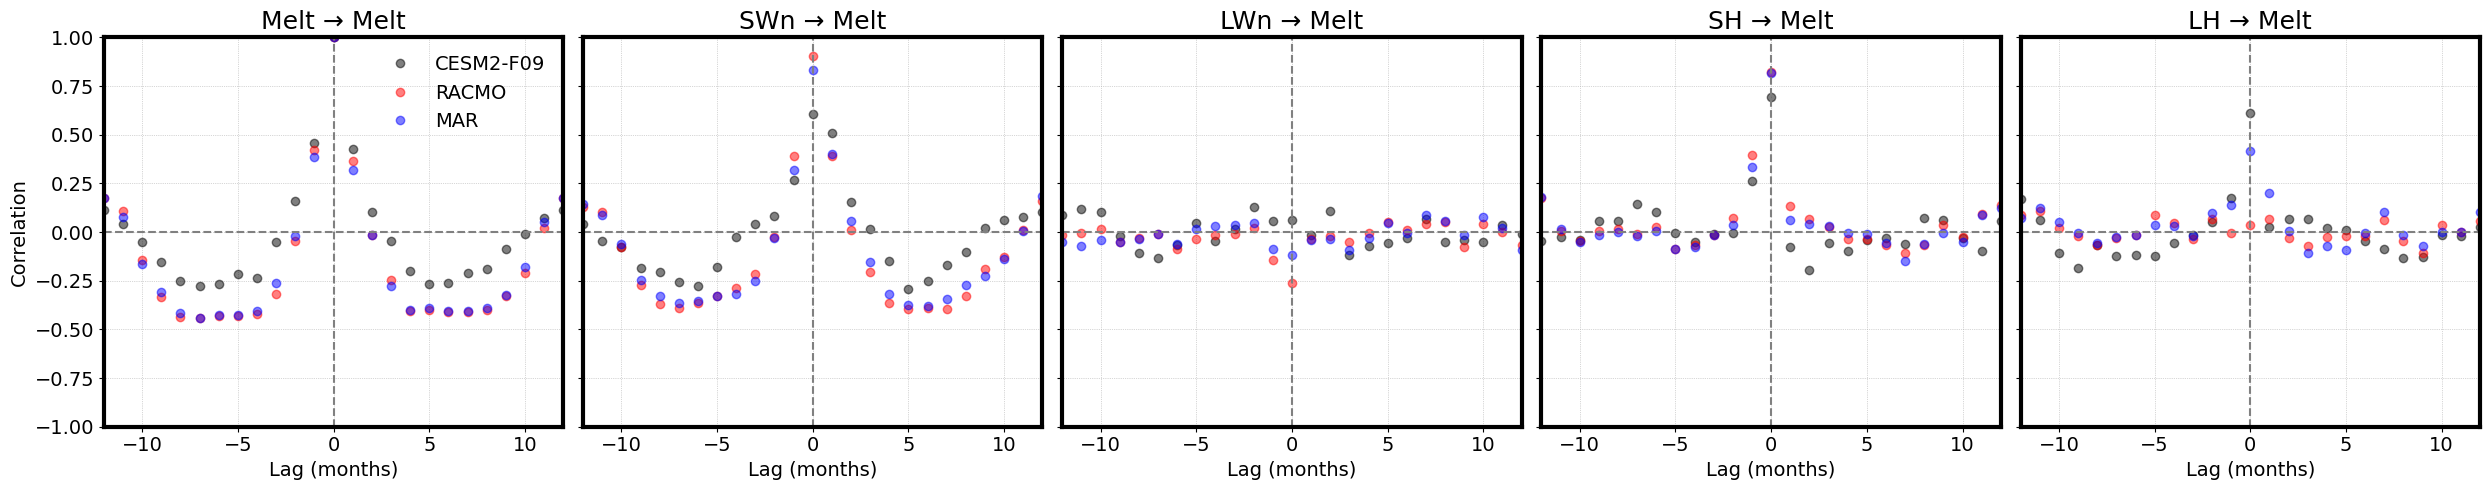

In [38]:
# === Plotting ===
fig, axs = plt.subplots(1, 5, figsize=(25, 5), sharey=True)
plt.rcParams["axes.linewidth"] = 3  # set the value globally

colors = {
    'CESM2-F09': 'black',
    'RACMO': 'red',
    'MAR': 'blue'
}

size_legend = 14
size_label = 14
size_title = 18
size_tick = 14

for idx, var in enumerate(variables):
    ax = axs[idx]
    for model_name in models.keys():
        ax.plot(lags, correlations[model_name][var], marker='o', linestyle='None', label=model_name, color=colors[model_name],alpha=0.5)
    ax.set_title(f'{var} → Melt', size=size_title)
    ax.set_xlabel('Lag (months)', size=size_label)
    if idx == 0:
        ax.set_ylabel('Correlation', size=size_label)
    ax.axhline(0, color='gray', linestyle='--')
    ax.axvline(0, color='gray', linestyle='--')
    ax.set_xlim(-12, 12)
    ax.set_ylim(-1, 1)
    ax.grid(True, linestyle=':', linewidth=0.5)
    #ax.xaxis.set_minor_locator(AutoMinorLocator())
    #ax.yaxis.set_minor_locator(AutoMinorLocator())
    #ax.tick_params(which="major", length=7, width=2, direction="in")
    #ax.tick_params(which="minor", length=4, direction="in")
    ax.tick_params(labelsize=size_tick)

axs[0].legend(loc="best", frameon=False, prop={"size": size_legend}, ncol=1)

plt.tight_layout()
plt.savefig(
    home_dir+'2023-GrIS-melt-causality/plot/physics/lagged_cor_melt_SEB_hist_anomaly.png',
    dpi=300,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)

#### With significance level

In [ ]:
# === Organize the data ===
models = {
    'CESM2-F09': [F09_melt, F09_SWn, F09_LWn, F09_SH, F09_LH],
    'RACMO': [RACMO_melt, RACMO_SWn, RACMO_LWn, RACMO_SH, RACMO_LH],
    'MAR': [MAR_melt, MAR_SWn, MAR_LWn, MAR_SH, MAR_LH]
}

variables = ['Melt', 'SWn', 'LWn', 'SH', 'LH']
lags = np.arange(-12, 13)  # -12 to 12 months

# === Custom function to construct JJA melt and lagged predictors ===
def extract_shifted_JJA(melt, var, lag):
    n_months = melt.shape[0]
    n_years = n_months // 12
    melt_JJA = []
    var_shifted = []
    for i in range(n_years):
        year_start = i * 12
        for j, month in enumerate([5, 6, 7]):  # June (5), July (6), August (7)
            melt_idx = year_start + month
            var_idx = melt_idx + lag
            if 0 <= var_idx < n_months and 0 <= melt_idx < n_months:
                melt_JJA.append(melt[melt_idx])
                var_shifted.append(var[var_idx])
    return np.array(melt_JJA), np.array(var_shifted)

# Fisher z-transform confidence interval function
def fisher_confidence_interval(r, n, alpha=0.1):
    if abs(r) == 1:
        return r, r  # Avoid infinite values for perfect correlation
    z = 0.5 * np.log((1 + r) / (1 - r))
    se = 1 / np.sqrt(n - 3)
    z_crit = 1.96  # For 95% confidence
    z_lower = z - z_crit * se
    z_upper = z + z_crit * se
    r_lower = (np.exp(2 * z_lower) - 1) / (np.exp(2 * z_lower) + 1)
    r_upper = (np.exp(2 * z_upper) - 1) / (np.exp(2 * z_upper) + 1)
    return r_lower, r_upper

# === Calculate lagged correlations and confidence intervals ===
correlations = {model: {var: [] for var in variables} for model in models.keys()}
conf_intervals = {model: {var: [] for var in variables} for model in models.keys()}

for model_name, (melt, SWn, LWn, SH, LH) in models.items():
    for var_name, var in zip(variables, [melt, SWn, LWn, SH, LH]):
        for lag in lags:
            melt_JJA, var_shifted = extract_shifted_JJA(melt, var, lag)
            if len(melt_JJA) > 3:  # Need at least 4 points to have confidence intervals
                corr, _ = pearsonr(var_shifted, melt_JJA)
                r_lower, r_upper = fisher_confidence_interval(corr, len(melt_JJA))
                correlations[model_name][var_name].append(corr)
                conf_intervals[model_name][var_name].append((r_lower, r_upper))
            else:
                correlations[model_name][var_name].append(np.nan)
                conf_intervals[model_name][var_name].append((np.nan, np.nan))

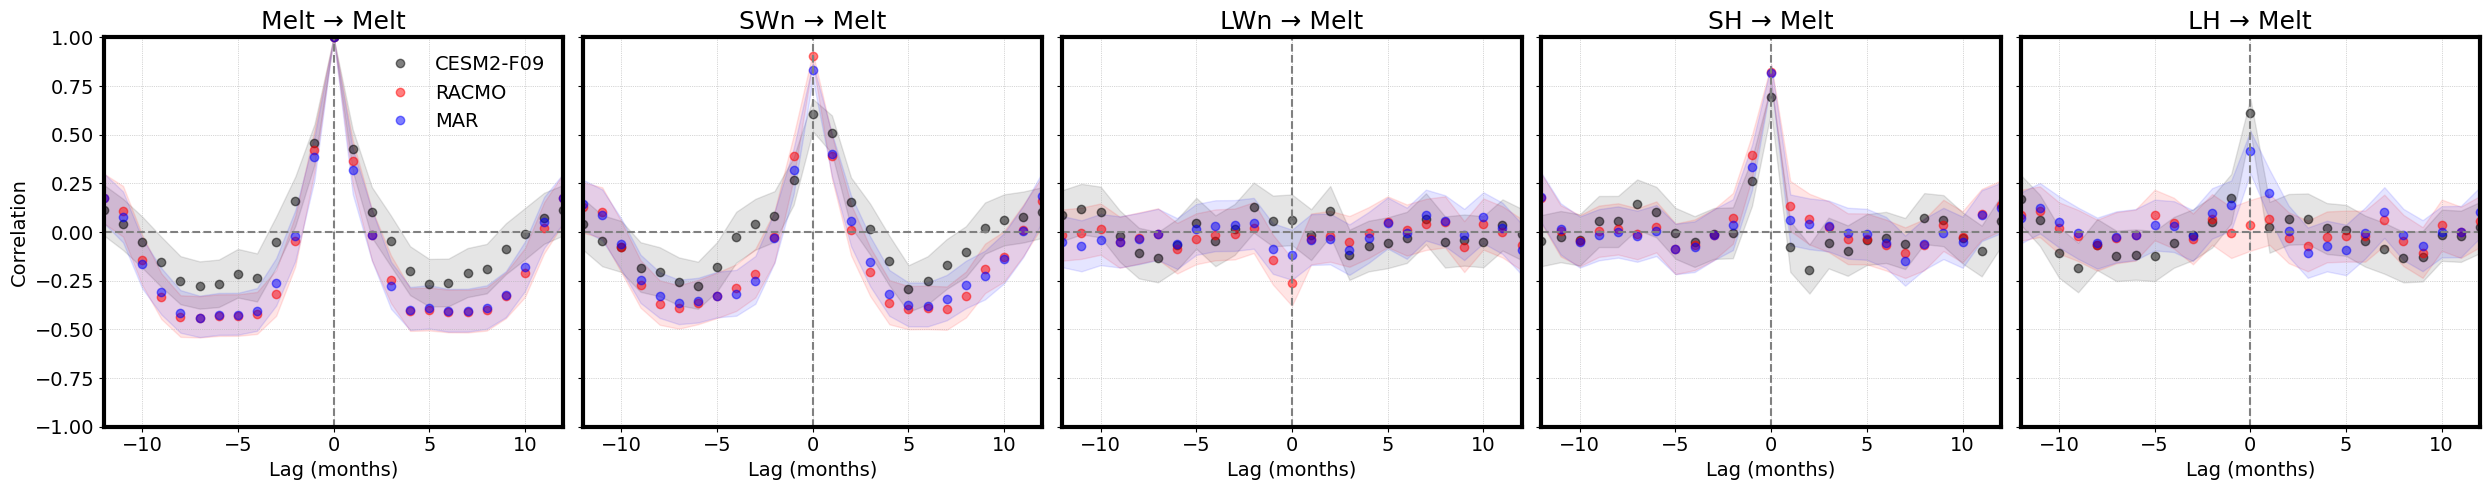

In [53]:
# === Plotting ===
fig, axs = plt.subplots(1, 5, figsize=(25, 5), sharey=True)
plt.rcParams["axes.linewidth"] = 3  # set the value globally

colors = {
    'CESM2-F09': 'black',
    'RACMO': 'red',
    'MAR': 'blue'
}

size_legend = 14
size_label = 14
size_title = 18
size_tick = 14

for idx, var in enumerate(variables):
    ax = axs[idx]
    for model_name in models.keys():
        r = np.array(correlations[model_name][var])
        ci = np.array(conf_intervals[model_name][var])
        r_lower = ci[:, 0]
        r_upper = ci[:, 1]
        
        # Plot dots
        ax.plot(lags, r, 'o', label=model_name, color=colors[model_name],alpha=0.5)
        
        # Plot confidence interval as shaded area
        ax.fill_between(lags, r_lower, r_upper, color=colors[model_name], alpha=0.1)
        
    ax.set_title(f'{var} → Melt', size=size_title)    
    ax.set_xlabel('Lag (months)', size=size_label)
    if idx == 0:
        ax.set_ylabel('Correlation', size=size_label)
    ax.axhline(0, color='gray', linestyle='--')
    ax.axvline(0, color='gray', linestyle='--')
    ax.set_xlim(-12, 12)
    ax.set_ylim(-1, 1)
    ax.grid(True, linestyle=':', linewidth=0.5)
    #ax.xaxis.set_minor_locator(AutoMinorLocator())
    #ax.yaxis.set_minor_locator(AutoMinorLocator())
    #ax.tick_params(which="major", length=7, width=2, direction="in")
    #ax.tick_params(which="minor", length=4, direction="in")
    ax.tick_params(labelsize=size_tick)

axs[0].legend(loc="best", frameon=False, prop={"size": size_legend}, ncol=1)

plt.tight_layout()
plt.savefig(
    home_dir+'2023-GrIS-melt-causality/plot/physics/lagged_cor_melt_SEB_hist_anomaly_CI90.png',
    dpi=300,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)

In [25]:
# === Organize the data ===
models = {
    'CESM2-F09': [F09_melt, F09_SWn, F09_LWn, F09_SH, F09_LH],  # shape (50, 360)
    'RACMO': [RACMO_melt, RACMO_SWn, RACMO_LWn, RACMO_SH, RACMO_LH],  # shape (360,)
    'MAR': [MAR_melt, MAR_SWn, MAR_LWn, MAR_SH, MAR_LH]  # shape (360,)
}

variables = ['Melt', 'SWn', 'LWn', 'SH', 'LH']
lags = np.arange(-12, 13)

# Custom function to construct JJA melt and lagged predictors
def extract_shifted_JJA(melt, var, lag):
    n_months = melt.shape[-1]
    n_years = n_months // 12
    melt_JJA = []
    var_shifted = []
    for i in range(n_years):
        year_start = i * 12
        for month in [5, 6, 7]:  # June (5), July (6), August (7)
            melt_idx = year_start + month
            var_idx = melt_idx + lag
            if 0 <= var_idx < n_months and 0 <= melt_idx < n_months:
                melt_JJA.append(melt[melt_idx])
                var_shifted.append(var[var_idx])
    return np.array(melt_JJA), np.array(var_shifted)

# Fisher z-transform confidence interval
def fisher_confidence_interval(r, n, alpha=0.1):
    if abs(r) == 1:
        return r, r
    z = 0.5 * np.log((1 + r) / (1 - r))
    se = 1 / np.sqrt(n - 3)
    z_crit = 1.64  # for 90% CI
    z_lower, z_upper = z - z_crit * se, z + z_crit * se
    r_lower = (np.exp(2 * z_lower) - 1) / (np.exp(2 * z_lower) + 1)
    r_upper = (np.exp(2 * z_upper) - 1) / (np.exp(2 * z_upper) + 1)
    return r_lower, r_upper

# === Calculate correlations ===
correlations = {model: {var: [] for var in variables} for model in models.keys()}
conf_intervals = {model: {var: [] for var in variables} for model in models.keys()}

for model_name, (melt, SWn, LWn, SH, LH) in models.items():
    for var_name, var in zip(variables, [melt, SWn, LWn, SH, LH]):
        for lag in lags:
            if model_name == 'CESM2-F09':
                # loop over ensemble members
                member_corrs = []
                for i in range(melt.shape[0]):
                    melt_i = melt[i, :]
                    var_i = var[i, :]
                    melt_JJA, var_shifted = extract_shifted_JJA(melt_i, var_i, lag)
                    if len(melt_JJA) > 3:
                        corr, _ = pearsonr(var_shifted, melt_JJA)
                        member_corrs.append(corr)
                if len(member_corrs) > 0:
                    corr_mean = np.nanmean(member_corrs)
                    r_lower, r_upper = fisher_confidence_interval(corr_mean, len(melt_JJA))
                    correlations[model_name][var_name].append(corr_mean)
                    conf_intervals[model_name][var_name].append((r_lower, r_upper))
                else:
                    correlations[model_name][var_name].append(np.nan)
                    conf_intervals[model_name][var_name].append((np.nan, np.nan))
            else:
                # RACMO & MAR
                melt_JJA, var_shifted = extract_shifted_JJA(melt, var, lag)
                if len(melt_JJA) > 3:
                    corr, _ = pearsonr(var_shifted, melt_JJA)
                    r_lower, r_upper = fisher_confidence_interval(corr, len(melt_JJA))
                    correlations[model_name][var_name].append(corr)
                    conf_intervals[model_name][var_name].append((r_lower, r_upper))
                else:
                    correlations[model_name][var_name].append(np.nan)
                    conf_intervals[model_name][var_name].append((np.nan, np.nan))

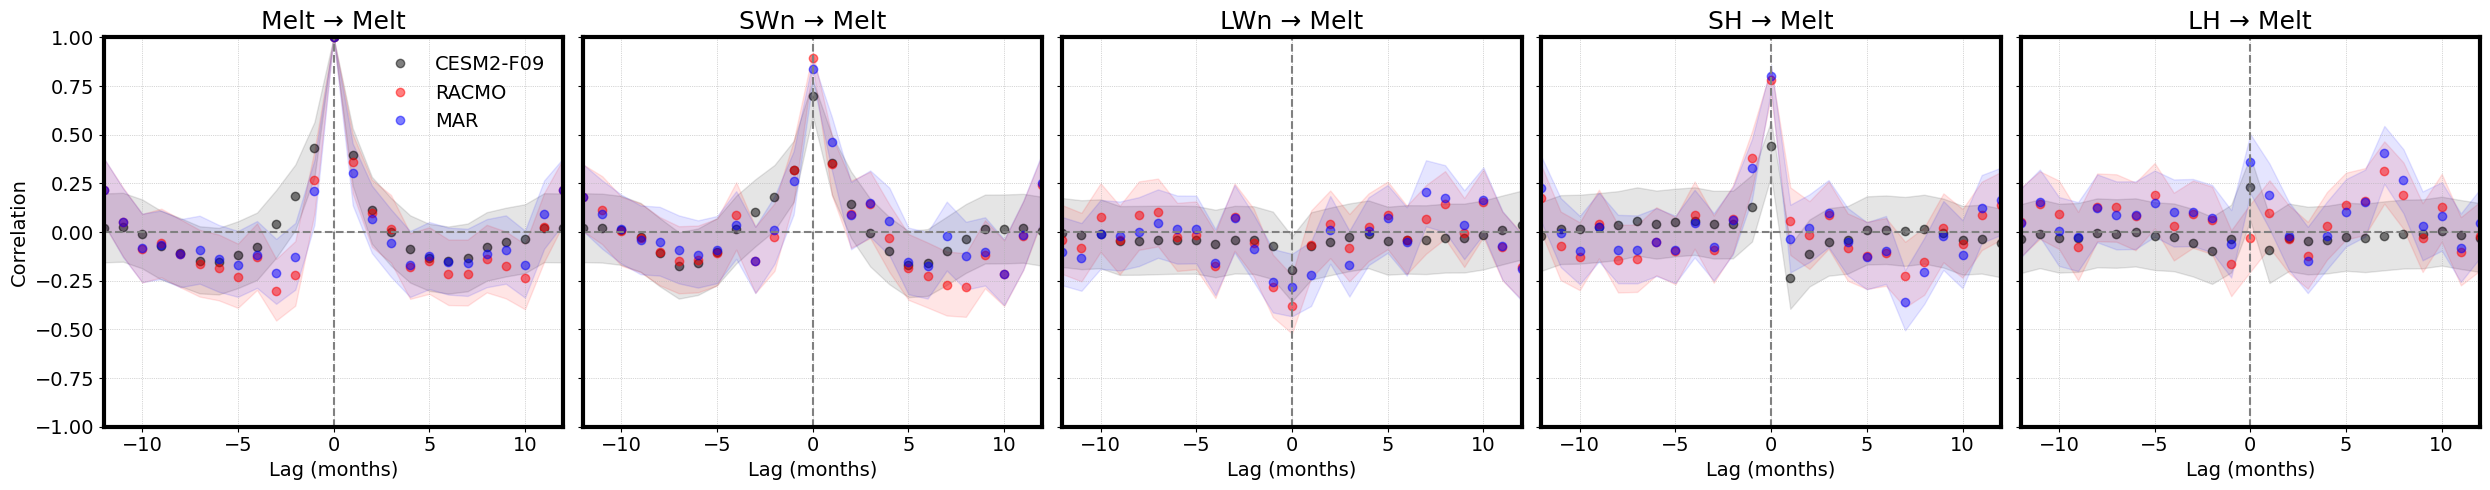

In [46]:
# === Plotting ===
fig, axs = plt.subplots(1, 5, figsize=(25, 5), sharey=True)
plt.rcParams["axes.linewidth"] = 3

colors = {'CESM2-F09': 'black', 'RACMO': 'red', 'MAR': 'blue'}
size_legend = 14
size_label = 14
size_title = 18
size_tick = 14

for idx, var in enumerate(variables):
    ax = axs[idx]
    for model_name in models.keys():
        r = np.array(correlations[model_name][var])
        ci = np.array(conf_intervals[model_name][var])
        r_lower = ci[:, 0]
        r_upper = ci[:, 1]

        ax.plot(lags, r, 'o', label=model_name, color=colors[model_name], alpha=0.5)
        ax.fill_between(lags, r_lower, r_upper, color=colors[model_name], alpha=0.1)
        
    ax.set_title(f'{var} → Melt', size=size_title)
    ax.set_xlabel('Lag (months)', size=size_label)
    if idx == 0:
        ax.set_ylabel('Correlation', size=size_label)
    ax.axhline(0, color='gray', linestyle='--')
    ax.axvline(0, color='gray', linestyle='--')
    ax.set_xlim(-12, 12)
    ax.set_ylim(-1, 1)
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.tick_params(labelsize=size_tick)

axs[0].legend(loc="best", frameon=False, prop={"size": size_legend}, ncol=1)
plt.tight_layout()

plt.savefig(
    home_dir + '2023-GrIS-melt-causality/plot/physics/lagged_cor_LENS2_melt_SEB_hist_1940_1969_anomaly_CI90.png',
    dpi=300, bbox_inches="tight", facecolor="w", transparent=False,
)

In [47]:
# === Organize the data ===
models = {
    'CESM2-F09': [F09_melt, F09_SWn, F09_LWn, F09_SH, F09_LH],  # shape (50, 360)
    'RACMO': [RACMO_melt, RACMO_SWn, RACMO_LWn, RACMO_SH, RACMO_LH],  # shape (360,)
    'MAR': [MAR_melt, MAR_SWn, MAR_LWn, MAR_SH, MAR_LH]  # shape (360,)
}

variables = ['Melt', 'SWn', 'LWn', 'SH', 'LH']
lags = np.arange(-12, 13)

# Custom function to construct JJA melt and lagged predictors
def extract_shifted_JJA(melt, var, lag):
    n_months = melt.shape[-1]
    n_years = n_months // 12
    melt_JJA = []
    var_shifted = []
    for i in range(n_years):
        year_start = i * 12
        for month in [5, 6, 7]:  # June (5), July (6), August (7)
            melt_idx = year_start + month
            var_idx = melt_idx + lag
            if 0 <= var_idx < n_months and 0 <= melt_idx < n_months:
                melt_JJA.append(melt[melt_idx])
                var_shifted.append(var[var_idx])
    return np.array(melt_JJA), np.array(var_shifted)

# === Store full individual member correlations ===
correlations = {model: {var: [] for var in variables} for model in models.keys()}

for model_name, (melt, SWn, LWn, SH, LH) in models.items():
    for var_name, var in zip(variables, [melt, SWn, LWn, SH, LH]):
        all_corrs = []  # store all lags
        for lag in lags:
            if model_name == 'CESM2-F09':
                member_corrs = []
                for i in range(melt.shape[0]):
                    melt_i = melt[i, :]
                    var_i = var[i, :]
                    melt_JJA, var_shifted = extract_shifted_JJA(melt_i, var_i, lag)
                    if len(melt_JJA) > 3:
                        corr, _ = pearsonr(var_shifted, melt_JJA)
                        member_corrs.append(corr)
                    else:
                        member_corrs.append(np.nan)
                all_corrs.append(member_corrs)
            else:
                melt_JJA, var_shifted = extract_shifted_JJA(melt, var, lag)
                if len(melt_JJA) > 3:
                    corr, _ = pearsonr(var_shifted, melt_JJA)
                    all_corrs.append(corr)
                else:
                    all_corrs.append(np.nan)
        correlations[model_name][var_name] = all_corrs

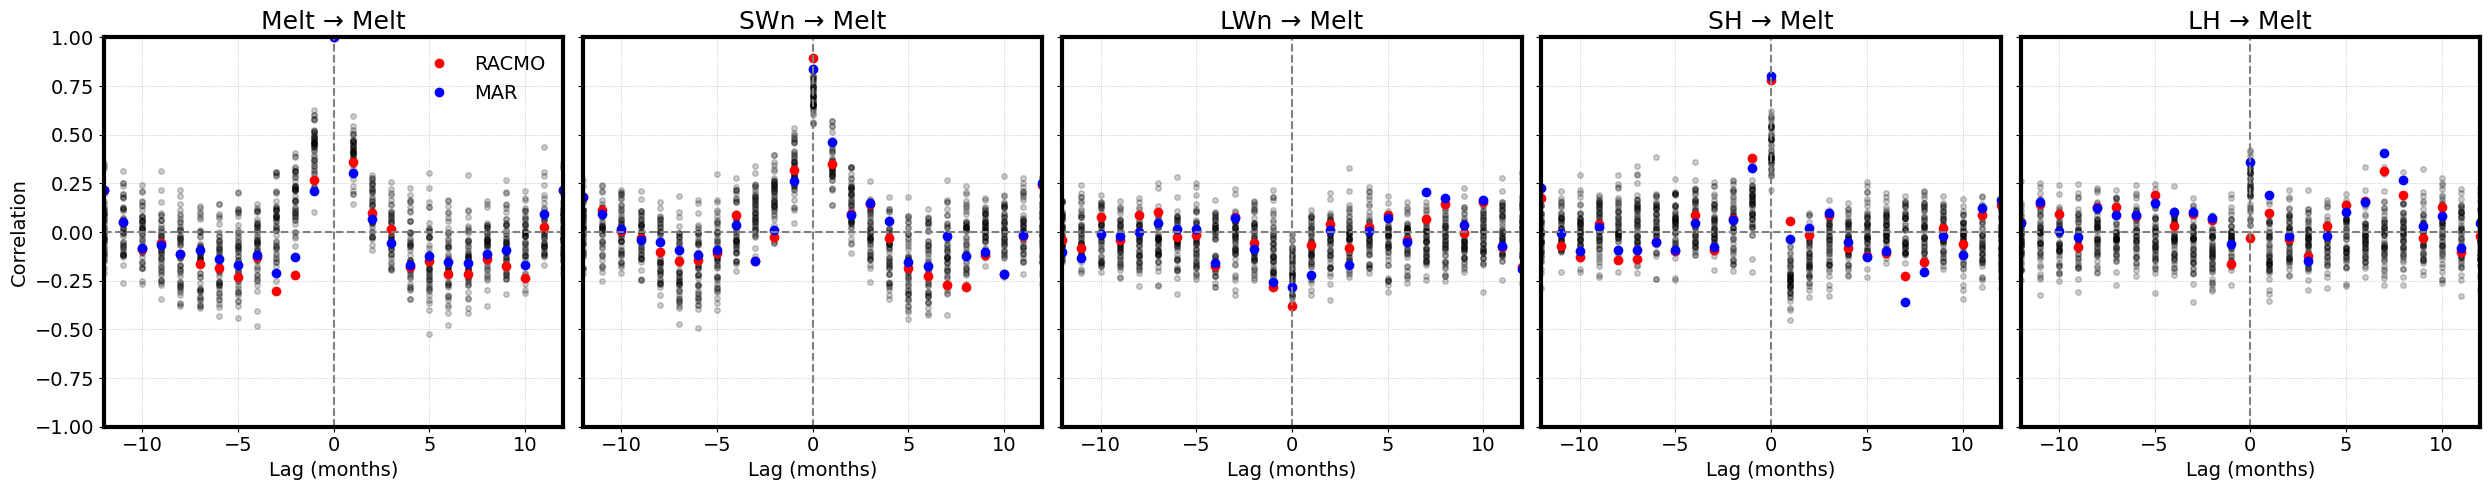

In [48]:
# === Plotting ===
fig, axs = plt.subplots(1, 5, figsize=(25, 5), sharey=True)
plt.rcParams["axes.linewidth"] = 3

colors = {'CESM2-F09': 'black', 'RACMO': 'red', 'MAR': 'blue'}
size_legend = 14
size_label = 14
size_title = 18
size_tick = 14

for idx, var in enumerate(variables):
    ax = axs[idx]
    for model_name in models.keys():
        data = correlations[model_name][var]
        if model_name == 'CESM2-F09':
            # data shape: list of lists [lags][members]
            for member in range(50):
                member_corrs = [data[lag_idx][member] for lag_idx in range(len(lags))]
                ax.plot(lags, member_corrs, 'o', color=colors[model_name], alpha=0.2, markersize=4)
        else:
            # RACMO and MAR
            r = np.array(data)
            ax.plot(lags, r, 'o', label=model_name, color=colors[model_name], markersize=6)

    ax.set_title(f'{var} → Melt', size=size_title)
    ax.set_xlabel('Lag (months)', size=size_label)
    if idx == 0:
        ax.set_ylabel('Correlation', size=size_label)
    ax.axhline(0, color='gray', linestyle='--')
    ax.axvline(0, color='gray', linestyle='--')
    ax.set_xlim(-12, 12)
    ax.set_ylim(-1, 1)
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.tick_params(labelsize=size_tick)

axs[0].legend(loc="best", frameon=False, prop={"size": size_legend}, ncol=1)
plt.tight_layout()

plt.savefig(
    home_dir + '2023-GrIS-melt-causality/plot/physics/lagged_cor_LENS2_melt_SEB_hist_1940_1969_anomaly_CI90.png',
    dpi=300, bbox_inches="tight", facecolor="w", transparent=False,
)

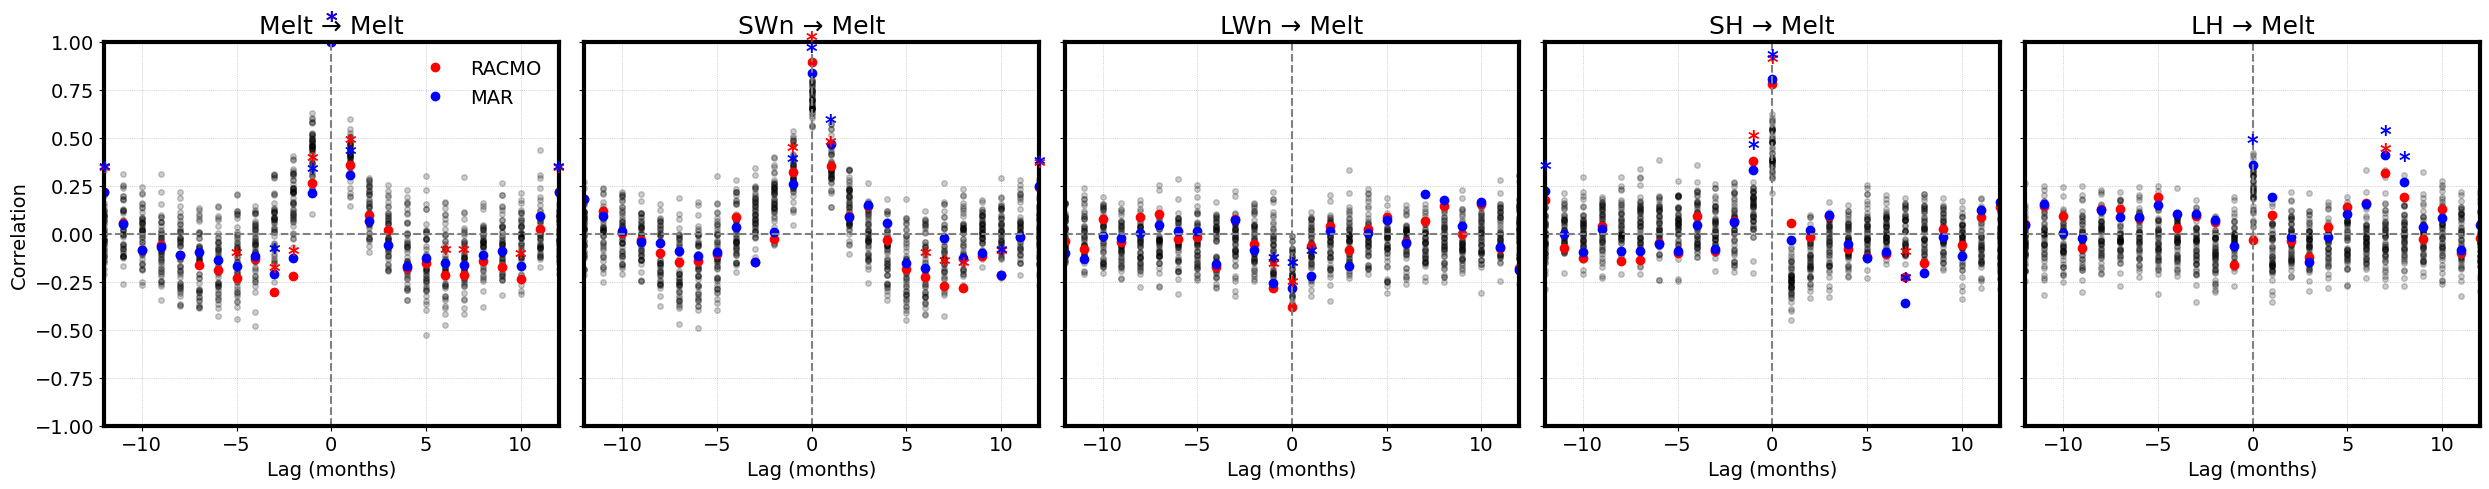

In [49]:
import numpy as np
from scipy.stats import pearsonr

# === Plotting ===
fig, axs = plt.subplots(1, 5, figsize=(25, 5), sharey=True)
plt.rcParams["axes.linewidth"] = 3

colors = {'CESM2-F09': 'black', 'RACMO': 'red', 'MAR': 'blue'}
size_legend = 14
size_label = 14
size_title = 18
size_tick = 14

for idx, var in enumerate(variables):
    ax = axs[idx]
    
    for model_name in models.keys():
        data = correlations[model_name][var]
        
        if model_name == 'CESM2-F09':
            # plot all 50 members
            for member in range(50):
                member_corrs = [data[lag_idx][member] for lag_idx in range(len(lags))]
                ax.plot(lags, member_corrs, 'o', color=colors[model_name], alpha=0.2, markersize=4)

        else:
            # RACMO and MAR: re-calculate p-values for significance
            r = np.array(data)
            pvals = []
            for lag_idx, lag in enumerate(lags):
                melt, flux = extract_shifted_JJA(
                    models[model_name][0],  # melt
                    models[model_name][variables.index(var)],  # flux
                    lag
                )
                if len(melt) > 3:
                    _, pval = pearsonr(flux, melt)
                    pvals.append(pval)
                else:
                    pvals.append(np.nan)
            
            ax.plot(lags, r, 'o', label=model_name, color=colors[model_name], markersize=6)
            
            # Add stars for p < 0.05
            for lag_val, corr_val, pval_val in zip(lags, r, pvals):
                if (not np.isnan(pval_val)) and pval_val < 0.05:
                    ax.text(lag_val, corr_val + 0.05, '*', ha='center', va='bottom', color=colors[model_name], fontsize=16, fontweight='bold')

    ax.set_title(f'{var} → Melt', size=size_title)
    ax.set_xlabel('Lag (months)', size=size_label)
    if idx == 0:
        ax.set_ylabel('Correlation', size=size_label)
    ax.axhline(0, color='gray', linestyle='--')
    ax.axvline(0, color='gray', linestyle='--')
    ax.set_xlim(-12, 12)
    ax.set_ylim(-1, 1)
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.tick_params(labelsize=size_tick)

axs[0].legend(loc="best", frameon=False, prop={"size": size_legend}, ncol=1)
plt.tight_layout()

plt.savefig(
    home_dir + '2023-GrIS-melt-causality/plot/physics/lagged_cor_LENS2_melt_SEB_hist_1940_1969_anomaly_CI90.png',
    dpi=300, bbox_inches="tight", facecolor="w", transparent=False,
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


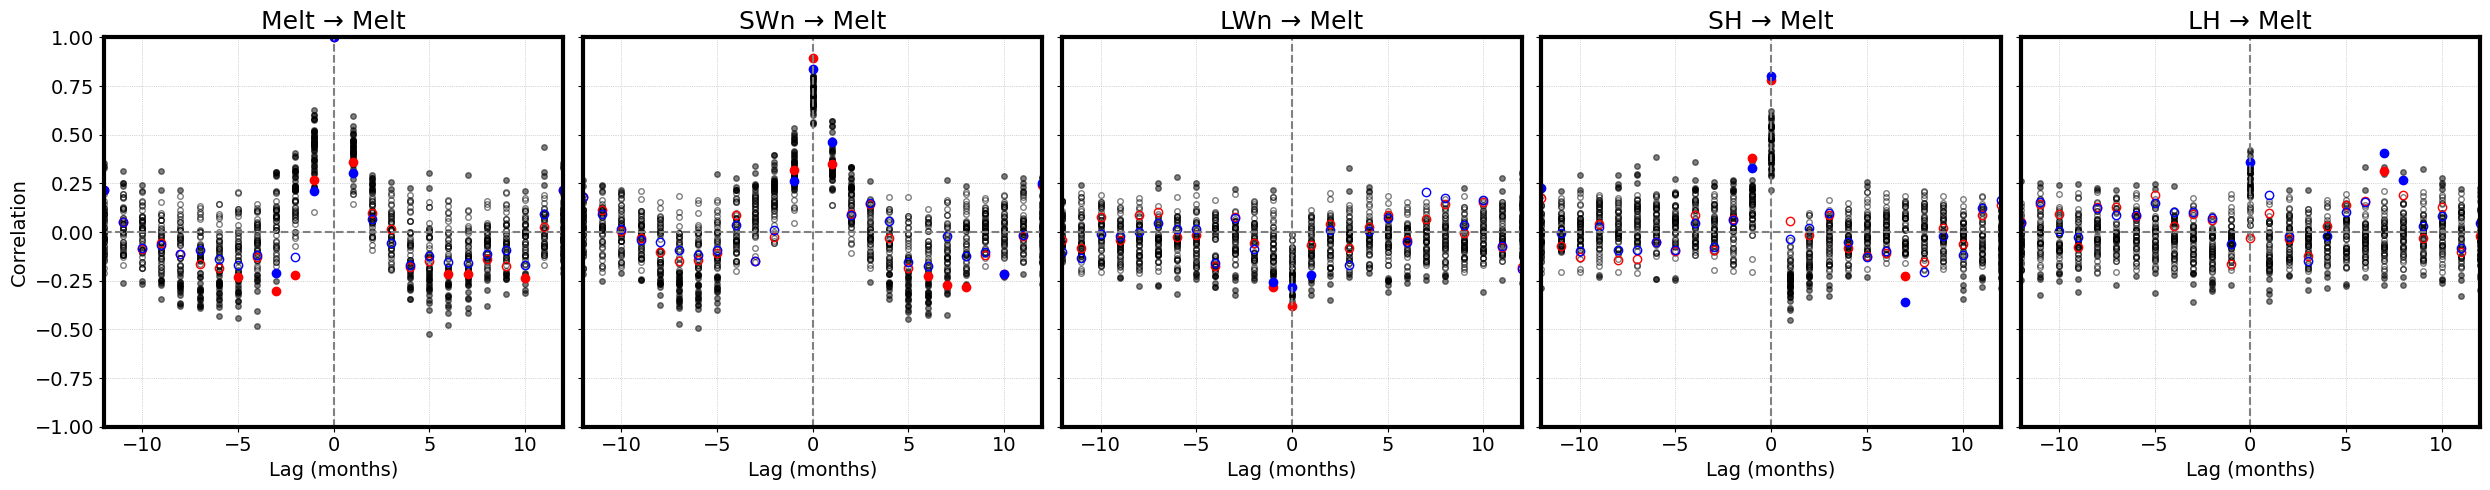

In [50]:
import numpy as np
from scipy.stats import pearsonr

# === Plotting ===
fig, axs = plt.subplots(1, 5, figsize=(25, 5), sharey=True)
plt.rcParams["axes.linewidth"] = 3

colors = {'CESM2-F09': 'black', 'RACMO': 'red', 'MAR': 'blue'}
size_legend = 14
size_label = 14
size_title = 18
size_tick = 14

for idx, var in enumerate(variables):
    ax = axs[idx]
    
    for model_name in models.keys():
        data = correlations[model_name][var]
        
        if model_name == 'CESM2-F09':
            # CESM2: loop over ensemble members
            for member in range(50):
                member_corrs = []
                member_pvals = []
                for lag_idx, lag in enumerate(lags):
                    melt_i = models[model_name][0][member, :]
                    var_i = models[model_name][variables.index(var)][member, :]
                    melt_JJA, var_shifted = extract_shifted_JJA(melt_i, var_i, lag)
                    if len(melt_JJA) > 3:
                        corr, pval = pearsonr(var_shifted, melt_JJA)
                        member_corrs.append(corr)
                        member_pvals.append(pval)
                    else:
                        member_corrs.append(np.nan)
                        member_pvals.append(np.nan)
                
                # plot each member as either filled or open dot
                for lag_val, corr_val, p_val in zip(lags, member_corrs, member_pvals):
                    if not np.isnan(p_val) and p_val < 0.05:
                        ax.plot(lag_val, corr_val, 'o', color=colors[model_name], markersize=4, alpha=0.5)
                    else:
                        ax.plot(lag_val, corr_val, 'o', markerfacecolor='none', markeredgecolor=colors[model_name], markersize=4, alpha=0.5)

        else:
            # RACMO and MAR
            r = np.array(data)
            pvals = []
            for lag_idx, lag in enumerate(lags):
                melt = models[model_name][0]
                var_flux = models[model_name][variables.index(var)]
                melt_JJA, var_shifted = extract_shifted_JJA(melt, var_flux, lag)
                if len(melt_JJA) > 3:
                    _, pval = pearsonr(var_shifted, melt_JJA)
                    pvals.append(pval)
                else:
                    pvals.append(np.nan)
            
            # plot RACMO/MAR as either filled or open circle
            for lag_val, corr_val, p_val in zip(lags, r, pvals):
                if not np.isnan(p_val) and p_val < 0.05:
                    ax.plot(lag_val, corr_val, 'o', color=colors[model_name], markersize=6)
                else:
                    ax.plot(lag_val, corr_val, 'o', markerfacecolor='none', markeredgecolor=colors[model_name], markersize=6)

    ax.set_title(f'{var} → Melt', size=size_title)
    ax.set_xlabel('Lag (months)', size=size_label)
    if idx == 0:
        ax.set_ylabel('Correlation', size=size_label)
    ax.axhline(0, color='gray', linestyle='--')
    ax.axvline(0, color='gray', linestyle='--')
    ax.set_xlim(-12, 12)
    ax.set_ylim(-1, 1)
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.tick_params(labelsize=size_tick)

axs[0].legend(loc="best", frameon=False, prop={"size": size_legend}, ncol=1)
plt.tight_layout()

plt.savefig(
    home_dir + '2023-GrIS-melt-causality/plot/physics/lagged_cor_LENS2_melt_SEB_hist_1940_1969_anomaly_sigtest.png',
    dpi=300, bbox_inches="tight", facecolor="w", transparent=False,
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


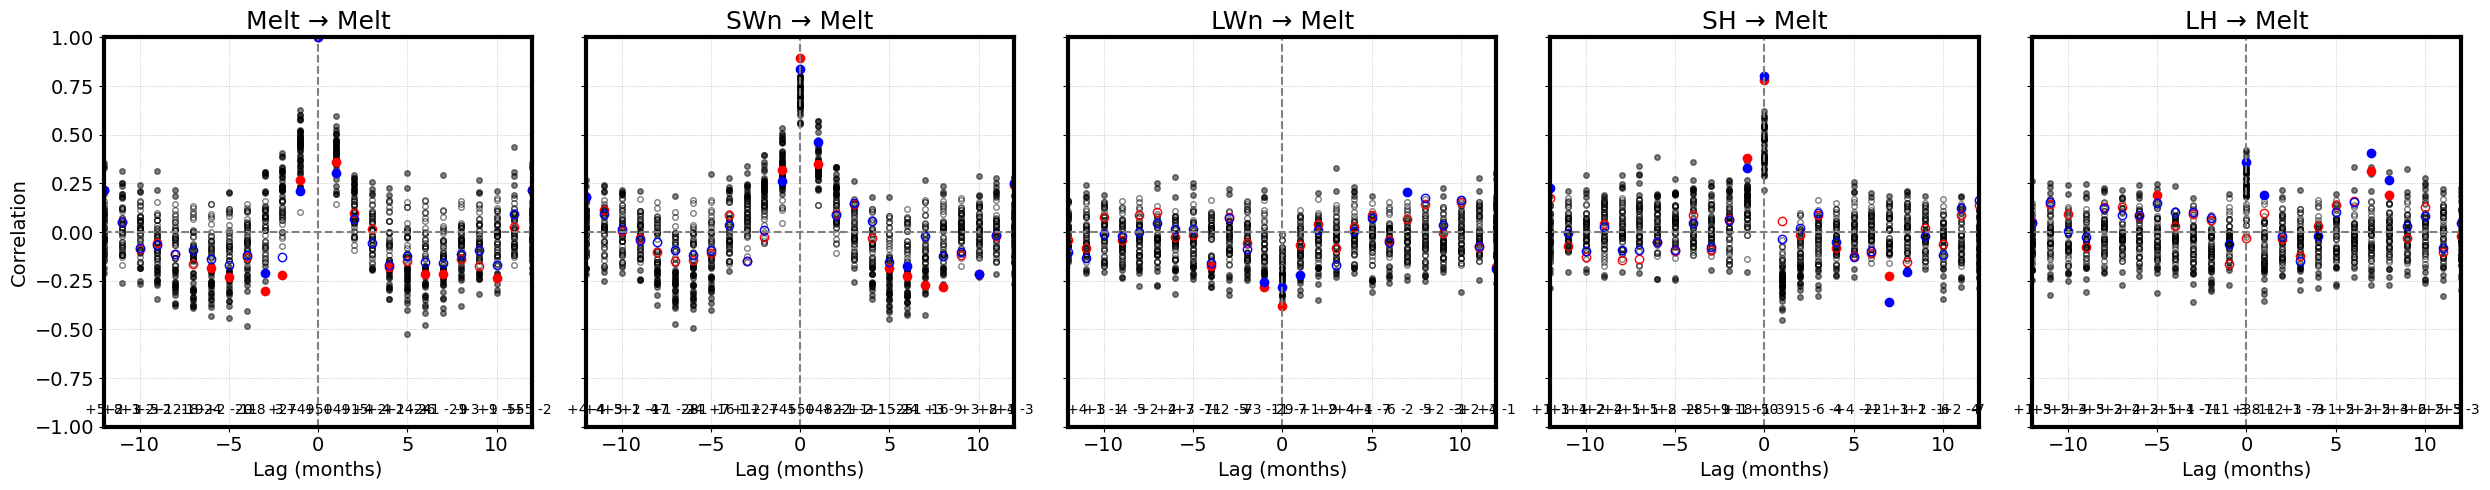

In [51]:
import numpy as np
from scipy.stats import pearsonr

# === Plotting ===
fig, axs = plt.subplots(1, 5, figsize=(25, 5), sharey=True)
plt.rcParams["axes.linewidth"] = 3

colors = {'CESM2-F09': 'black', 'RACMO': 'red', 'MAR': 'blue'}
size_legend = 14
size_label = 14
size_title = 18
size_tick = 14

for idx, var in enumerate(variables):
    ax = axs[idx]
    
    for model_name in models.keys():
        data = correlations[model_name][var]
        
        if model_name == 'CESM2-F09':
            # Prepare counters for CESM2-F09 significance summary
            sig_counts_pos = np.zeros(len(lags), dtype=int)
            sig_counts_neg = np.zeros(len(lags), dtype=int)
            
            # CESM2: loop over ensemble members
            for member in range(50):
                member_corrs = []
                member_pvals = []
                for lag_idx, lag in enumerate(lags):
                    melt_i = models[model_name][0][member, :]
                    var_i = models[model_name][variables.index(var)][member, :]
                    melt_JJA, var_shifted = extract_shifted_JJA(melt_i, var_i, lag)
                    if len(melt_JJA) > 3:
                        corr, pval = pearsonr(var_shifted, melt_JJA)
                        member_corrs.append(corr)
                        member_pvals.append(pval)
                        # Count significance
                        if pval < 0.1:
                            if corr > 0:
                                sig_counts_pos[lag_idx] += 1
                            elif corr < 0:
                                sig_counts_neg[lag_idx] += 1
                    else:
                        member_corrs.append(np.nan)
                        member_pvals.append(np.nan)
                
                # plot each member
                for lag_val, corr_val, p_val in zip(lags, member_corrs, member_pvals):
                    if not np.isnan(p_val) and p_val < 0.1:
                        ax.plot(lag_val, corr_val, 'o', color=colors[model_name], markersize=4, alpha=0.5)
                    else:
                        ax.plot(lag_val, corr_val, 'o', markerfacecolor='none', markeredgecolor=colors[model_name], markersize=4, alpha=0.5)

        else:
            # RACMO and MAR
            r = np.array(data)
            pvals = []
            for lag_idx, lag in enumerate(lags):
                melt = models[model_name][0]
                var_flux = models[model_name][variables.index(var)]
                melt_JJA, var_shifted = extract_shifted_JJA(melt, var_flux, lag)
                if len(melt_JJA) > 3:
                    _, pval = pearsonr(var_shifted, melt_JJA)
                    pvals.append(pval)
                else:
                    pvals.append(np.nan)
            
            for lag_val, corr_val, p_val in zip(lags, r, pvals):
                if not np.isnan(p_val) and p_val < 0.1:
                    ax.plot(lag_val, corr_val, 'o', color=colors[model_name], markersize=6)
                else:
                    ax.plot(lag_val, corr_val, 'o', markerfacecolor='none', markeredgecolor=colors[model_name], markersize=6)

    # === Add CESM2-F09 significance counts as annotation ===
    for lag_idx, lag_val in enumerate(lags):
        pos_count = sig_counts_pos[lag_idx]
        neg_count = sig_counts_neg[lag_idx]
        text_str = ''
        if pos_count > 0:
            text_str += f'+{pos_count}'
        if neg_count > 0:
            if text_str != '':
                text_str += ' '
            text_str += f'-{neg_count}'
        if text_str != '':
            ax.text(lag_val, -0.95, text_str, ha='center', va='bottom', fontsize=10, color='black')

    ax.set_title(f'{var} → Melt', size=size_title)
    ax.set_xlabel('Lag (months)', size=size_label)
    if idx == 0:
        ax.set_ylabel('Correlation', size=size_label)
    ax.axhline(0, color='gray', linestyle='--')
    ax.axvline(0, color='gray', linestyle='--')
    ax.set_xlim(-12, 12)
    ax.set_ylim(-1, 1)
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.tick_params(labelsize=size_tick)

axs[0].legend(loc="best", frameon=False, prop={"size": size_legend}, ncol=1)
plt.tight_layout()

plt.savefig(
    home_dir + '2023-GrIS-melt-causality/plot/physics/lagged_cor_LENS2_melt_SEB_hist_1940_1969_anomaly_CI90_sigcount.png',
    dpi=300, bbox_inches="tight", facecolor="w", transparent=False,
)

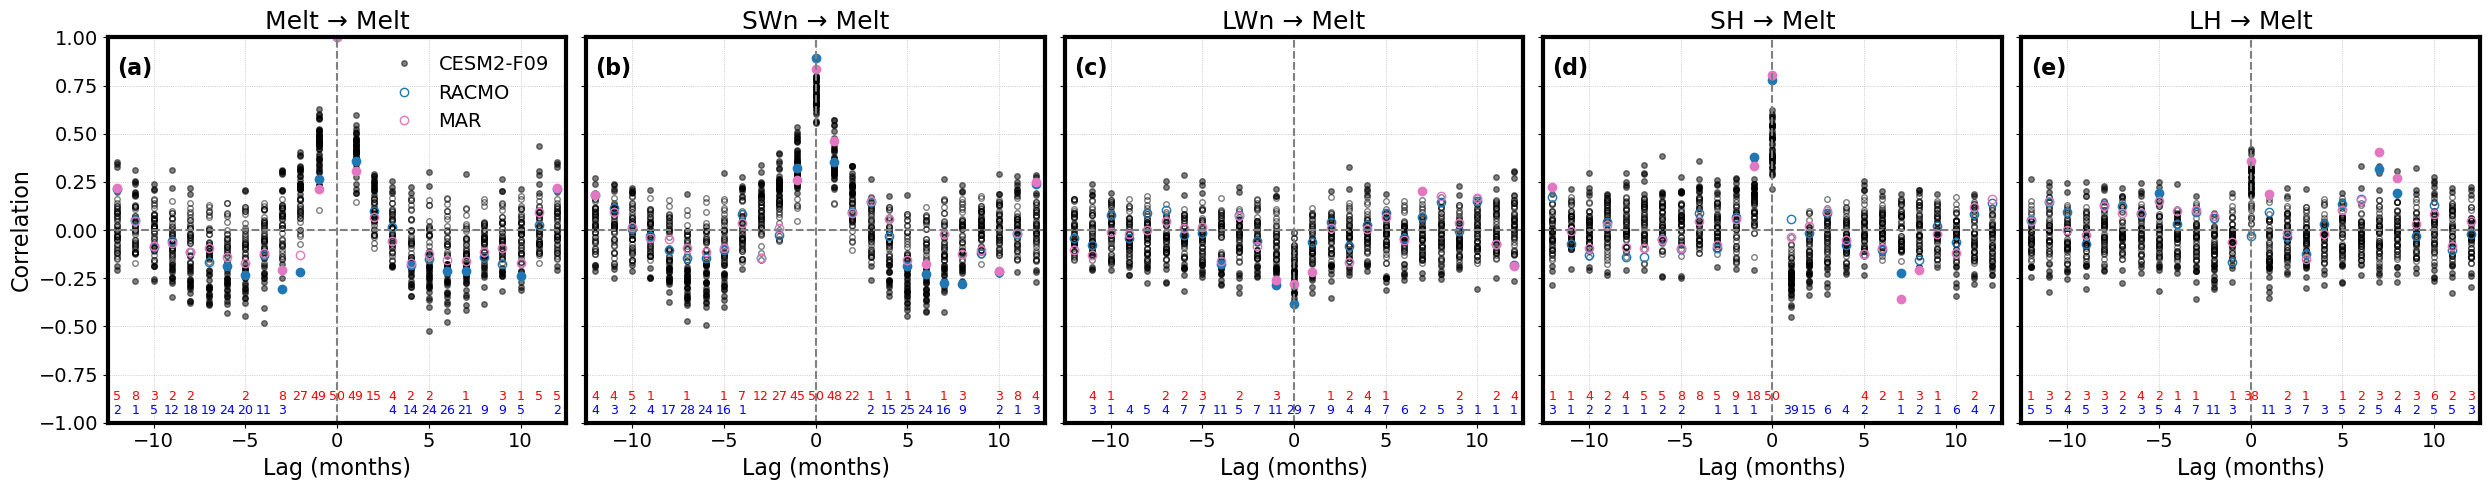

In [43]:
import numpy as np
from scipy.stats import pearsonr

# === Plotting ===
fig, axs = plt.subplots(1, 5, figsize=(25, 5), sharey=True)
plt.rcParams["axes.linewidth"] = 3

colors = {'CESM2-F09': 'black', 'RACMO': '#1F77B4', 'MAR': '#E377C2'}
size_legend = 14
size_label = 16
size_title = 18
size_tick = 14

for idx, var in enumerate(variables):
    ax = axs[idx]
    
    for model_name in models.keys():
        data = correlations[model_name][var]
        
        if model_name == 'CESM2-F09':
            # Prepare counters for CESM2-F09 significance summary
            sig_counts_pos = np.zeros(len(lags), dtype=int)
            sig_counts_neg = np.zeros(len(lags), dtype=int)
            
            # CESM2: loop over ensemble members
            for member in range(50):
                member_corrs = []
                member_pvals = []
                for lag_idx, lag in enumerate(lags):
                    melt_i = models[model_name][0][member, :]
                    var_i = models[model_name][variables.index(var)][member, :]
                    melt_JJA, var_shifted = extract_shifted_JJA(melt_i, var_i, lag)
                    if len(melt_JJA) > 3:
                        corr, pval = pearsonr(var_shifted, melt_JJA)
                        member_corrs.append(corr)
                        member_pvals.append(pval)
                        # Count significance
                        if pval < 0.1:
                            if corr > 0:
                                sig_counts_pos[lag_idx] += 1
                            elif corr < 0:
                                sig_counts_neg[lag_idx] += 1
                    else:
                        member_corrs.append(np.nan)
                        member_pvals.append(np.nan)
                
                # plot each member
                for lag_val, corr_val, p_val in zip(lags, member_corrs, member_pvals):
                    plot_label = model_name if member == 0 and lag_val == lags[4] else None
                    if not np.isnan(p_val) and p_val < 0.1:
                        ax.plot(lag_val, corr_val, 'o', color=colors[model_name], markersize=4, alpha=0.5, label=plot_label)
                    else:
                        ax.plot(lag_val, corr_val, 'o', markerfacecolor='none', markeredgecolor=colors[model_name], markersize=4, alpha=0.5, label=plot_label)

        else:
            # RACMO and MAR
            r = np.array(data)
            pvals = []
            for lag_idx, lag in enumerate(lags):
                melt = models[model_name][0]
                var_flux = models[model_name][variables.index(var)]
                melt_JJA, var_shifted = extract_shifted_JJA(melt, var_flux, lag)
                if len(melt_JJA) > 3:
                    _, pval = pearsonr(var_shifted, melt_JJA)
                    pvals.append(pval)
                else:
                    pvals.append(np.nan)
            
            for lag_val, corr_val, p_val in zip(lags, r, pvals):
                plot_label = model_name if lag_val == lags[4] else None
                if not np.isnan(p_val) and p_val < 0.1:
                    ax.plot(lag_val, corr_val, 'o', color=colors[model_name], markersize=6, label=plot_label)
                else:
                    ax.plot(lag_val, corr_val, 'o', markerfacecolor='none', markeredgecolor=colors[model_name], markersize=6, label=plot_label)

    # === Add CESM2-F09 significance counts: vertical stacking + color ===
    for lag_idx, lag_val in enumerate(lags):
        pos_count = sig_counts_pos[lag_idx]
        neg_count = sig_counts_neg[lag_idx]
        
        if pos_count > 0:
            ax.text(lag_val, -0.9, f'{pos_count}', ha='center', va='bottom',
                    fontsize=9, color='red')
        if neg_count > 0:
            ax.text(lag_val, -0.97, f'{neg_count}', ha='center', va='bottom',
                    fontsize=9, color='blue')

    ax.set_title(f'{var} → Melt', size=size_title)
    ax.set_xlabel('Lag (months)', size=size_label)
    if idx == 0:
        ax.set_ylabel('Correlation', size=size_label)
    ax.axhline(0, color='gray', linestyle='--')
    ax.axvline(0, color='gray', linestyle='--')
    ax.set_xlim(-12.5, 12.5)
    ax.set_ylim(-1, 1)
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.tick_params(labelsize=size_tick)

# Add subplot label (a)-(e)
panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)']

for idx, var in enumerate(variables):
    ax = axs[idx]

    # [rest of your plotting code...]

    # Add subplot label
    ax.text(0.02, 0.95, panel_labels[idx], transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='left')

    # Only add legend in panel (a)
    if idx == 0:
        ax.legend(loc="upper right", frameon=False, prop={"size": size_legend}, ncol=1)

plt.tight_layout()

plt.savefig(
    home_dir + '2023-GrIS-melt-causality/plot/physics/lagged_cor_LENS2_melt_SEB_hist_1940_1969_anomaly_CI90_sigcount.png',
    dpi=300, bbox_inches="tight", facecolor="w", transparent=False,
)

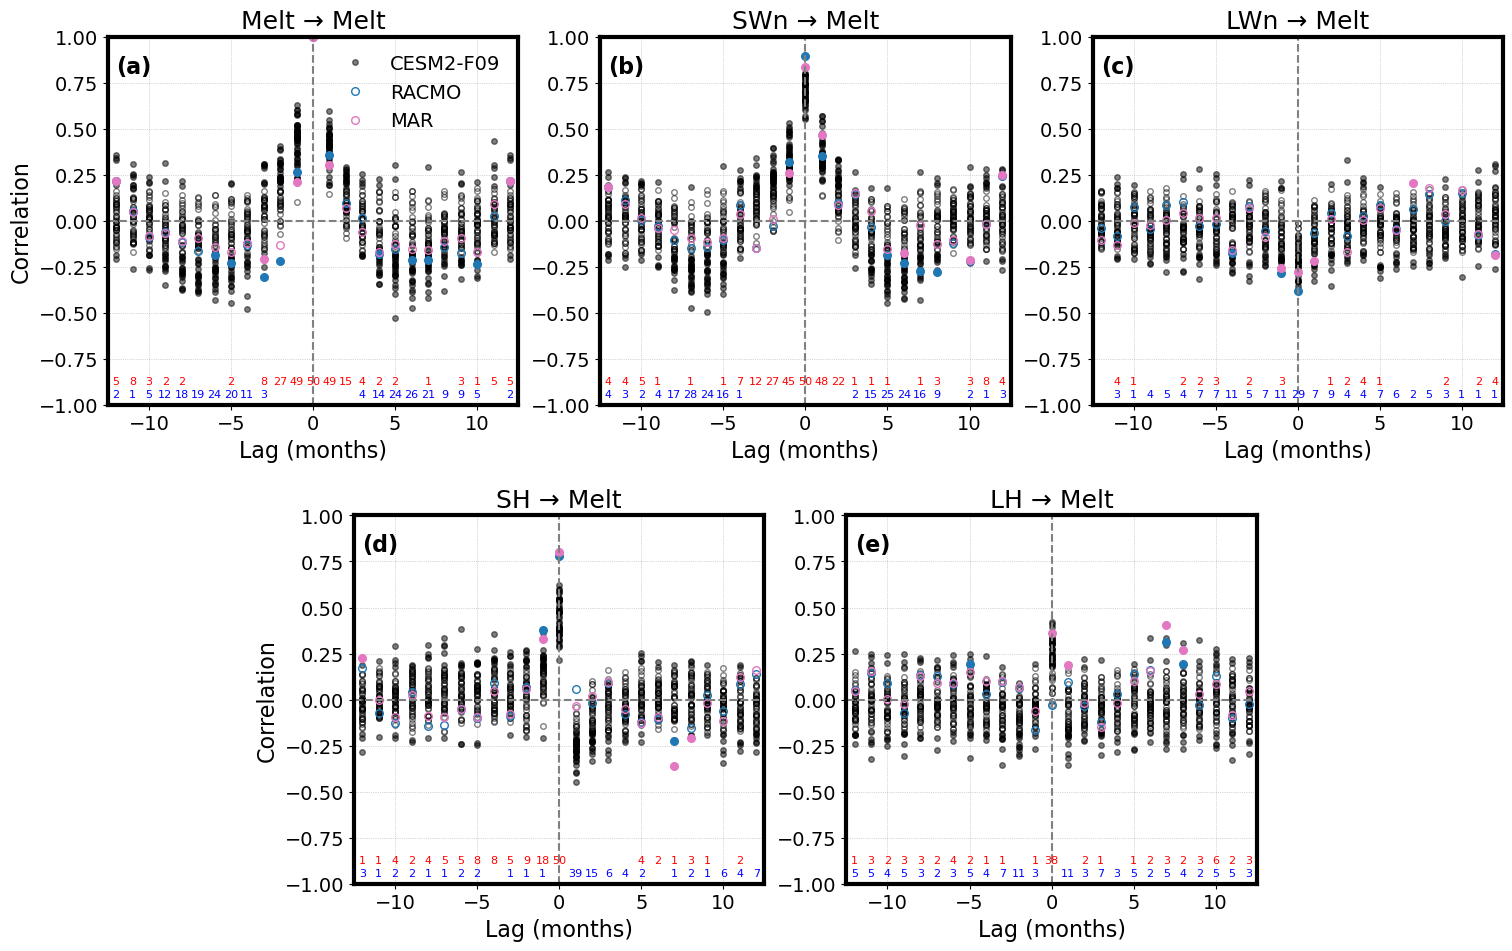

In [42]:
# Plot in 2 lines
import numpy as np
from scipy.stats import pearsonr
import matplotlib.gridspec as gridspec

# === Plotting ===
fig = plt.figure(figsize=(18, 11))  # Make taller to fit 2 rows
gs = gridspec.GridSpec(2, 6, figure=fig, hspace=0.3, wspace=0.5)#, height_ratios=[1, 1])

# Create list of axes in desired layout
axs = [
    fig.add_subplot(gs[0, 0:2]),  # Top-left
    fig.add_subplot(gs[0, 2:4]),  # Top-middle
    fig.add_subplot(gs[0, 4:6]),  # Top-right
    fig.add_subplot(gs[1, 1:3]),  # Bottom row, center-left and center column merged
    fig.add_subplot(gs[1, 3:5])   # Bottom-right
]

plt.rcParams["axes.linewidth"] = 3

colors = {'CESM2-F09': 'black', 'RACMO': '#1F77B4', 'MAR': '#E377C2'}
size_legend = 14
size_label = 16
size_title = 18
size_tick = 14
size_text = 8

for idx, var in enumerate(variables):
    ax = axs[idx]
    
    for model_name in models.keys():
        data = correlations[model_name][var]
        
        if model_name == 'CESM2-F09':
            # Prepare counters for CESM2-F09 significance summary
            sig_counts_pos = np.zeros(len(lags), dtype=int)
            sig_counts_neg = np.zeros(len(lags), dtype=int)
            
            # CESM2: loop over ensemble members
            for member in range(50):
                member_corrs = []
                member_pvals = []
                for lag_idx, lag in enumerate(lags):
                    melt_i = models[model_name][0][member, :]
                    var_i = models[model_name][variables.index(var)][member, :]
                    melt_JJA, var_shifted = extract_shifted_JJA(melt_i, var_i, lag)
                    if len(melt_JJA) > 3:
                        corr, pval = pearsonr(var_shifted, melt_JJA)
                        member_corrs.append(corr)
                        member_pvals.append(pval)
                        # Count significance
                        if pval < 0.1:
                            if corr > 0:
                                sig_counts_pos[lag_idx] += 1
                            elif corr < 0:
                                sig_counts_neg[lag_idx] += 1
                    else:
                        member_corrs.append(np.nan)
                        member_pvals.append(np.nan)
                
                # plot each member
                for lag_val, corr_val, p_val in zip(lags, member_corrs, member_pvals):
                    plot_label = model_name if member == 0 and lag_val == lags[4] else None
                    if not np.isnan(p_val) and p_val < 0.1:
                        ax.plot(lag_val, corr_val, 'o', color=colors[model_name], markersize=4, alpha=0.5, label=plot_label)
                    else:
                        ax.plot(lag_val, corr_val, 'o', markerfacecolor='none', markeredgecolor=colors[model_name], markersize=4, alpha=0.5, label=plot_label)

        else:
            # RACMO and MAR
            r = np.array(data)
            pvals = []
            for lag_idx, lag in enumerate(lags):
                melt = models[model_name][0]
                var_flux = models[model_name][variables.index(var)]
                melt_JJA, var_shifted = extract_shifted_JJA(melt, var_flux, lag)
                if len(melt_JJA) > 3:
                    _, pval = pearsonr(var_shifted, melt_JJA)
                    pvals.append(pval)
                else:
                    pvals.append(np.nan)
            
            for lag_val, corr_val, p_val in zip(lags, r, pvals):
                plot_label = model_name if lag_val == lags[4] else None
                if not np.isnan(p_val) and p_val < 0.1:
                    ax.plot(lag_val, corr_val, 'o', color=colors[model_name], markersize=5.5, label=plot_label)
                else:
                    ax.plot(lag_val, corr_val, 'o', markerfacecolor='none', markeredgecolor=colors[model_name], markersize=5.5, label=plot_label)

    # === Add CESM2-F09 significance counts: vertical stacking + color ===
    for lag_idx, lag_val in enumerate(lags):
        pos_count = sig_counts_pos[lag_idx]
        neg_count = sig_counts_neg[lag_idx]
        
        if pos_count > 0:
            ax.text(lag_val, -0.9, f'{pos_count}', ha='center', va='bottom',
                    fontsize=size_text, color='red')
        if neg_count > 0:
            ax.text(lag_val, -0.97, f'{neg_count}', ha='center', va='bottom',
                    fontsize=size_text, color='blue')

    ax.set_title(f'{var} → Melt', size=size_title)
    ax.set_xlabel('Lag (months)', size=size_label)
    if idx == 0 or idx == 3:
        ax.set_ylabel('Correlation', size=size_label)
    ax.axhline(0, color='gray', linestyle='--')
    ax.axvline(0, color='gray', linestyle='--')
    ax.set_xlim(-12.5, 12.5)
    ax.set_ylim(-1, 1)
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.tick_params(labelsize=size_tick)

# Add subplot label (a)-(e)
panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)']

for idx, var in enumerate(variables):
    ax = axs[idx]

    # [rest of your plotting code...]

    # Add subplot label
    ax.text(0.02, 0.95, panel_labels[idx], transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='left')

    # Only add legend in panel (a)
    if idx == 0:
        ax.legend(loc="upper right", frameon=False, prop={"size": size_legend}, ncol=1)

plt.tight_layout()

plt.savefig(
    home_dir + '2023-GrIS-melt-causality/plot/physics/lagged_cor_LENS2_melt_SEB_hist_1940_1969_anomaly_CI90_sigcount_2lines.png',
    dpi=600, bbox_inches="tight", facecolor="w", transparent=False,
)

In [15]:
# Make sure RCMS' time series are correct